# Wrangle and Analyze Data

In this document I'll gather, assess and clean the tweet archive of Twitter user **@dog_rates**. For that I will gather data from these three sources:

- A `csv` file containing the Tweet-Archive provided by Udacity.
- A `tsv` file containing image prediction information produced with a neural network provided by Udacity as well.
- Tweet metadata using Twitter API.

This data is then assessed for quality and tidiness. Afterwards the issues found are cleaned using Python and its libraries. Finally this wrangling is then showcased through analyses and visualizations.

***

## Gathering

### Setup

In this section the required packages were imported and needed variables were initialized.

#### Package-Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import tweepy
import json
import re
from matplotlib.ticker import FuncFormatter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from pathlib import Path
from lxml import etree
% matplotlib inline

#### Variables

Create some variables at the header so that this can be controlled here. Other variables might be created later as needed.

In [2]:
# file name of offline data
twitter_archive = 'twitter-archive-enhanced.csv'

# result file names
twitter_archive_master = 'twitter_archive_master.csv'
twitter_media_master = 'twitter_archive_media.csv'

# file name to store JSON data quried by the API
twitter_json_data = 'tweet_json.txt'

# file name to download containing the image predictions
# as a simple cache is used store filename and URL in two variables
image_predictions_file = 'image-predictions.tsv'
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions'

# create a path object - the file does not need to exist for that
image_predictions_path = Path(image_predictions_file)

# boolean to control whether the cached predictions file was downloaded
# and hence the Twitter API should be queried again
reload_twitter_data = False

# Python module containing Twitter API variables
# -- ensure to create a file twitter_tokens.py containing your twitter keys
#    or change import statements to 
# consumer_key = 'YOUR CONSUMER KEY'
# consumer_secret = 'YOUR CONSUMER SECRET'
# access_token = 'YOUR ACCESS TOKEN'
# access_secret = 'YOUR ACCESS SECRET'
from twitter_tokens import consumer_key, consumer_secret, access_token, access_secret

### Data-Import

#### Import of Twitter Offline Archive

This data is already available local and hence can be imported into a DataFrame using `read_csv` from Pandas.

In [3]:
df_tae = pd.read_csv(twitter_archive, encoding='utf-8')

#### Import of Image Predictions

A `tsv` file is available online. It is downloaded using the library `requests`. But to be able to use the file when being offline a simple manually *caching* is used: If the file already exists only the headers of the original file are requested. If the file is newer than the last modified date on disk or the size differs it is downloaded and stored on disk. When being offline neither request will work and hence the file is loaded directly if it is available.

In [4]:
if image_predictions_path.is_file():
    try:
        headers = requests.head('{}/{}'.format(image_predictions_url, image_predictions_file)).headers
        content_length = int(headers['Content-Length'])
        last_modified = datetime.strptime(headers['Last-Modified'], "%a, %d %b %Y %H:%M:%S GMT")
        os_file_size = image_predictions_path.stat().st_size
        os_file_mtime = datetime.fromtimestamp(image_predictions_path.stat().st_mtime)
        if content_length != os_file_size or last_modified > os_file_mtime:
            response = requests.get('{}/{}'.format(image_predictions_url, image_predictions_file))
            with open(image_predictions_file, mode='w', encoding='utf-8') as file:
                file.write(response.text)
            response.close()
            # if predictions are downloaded just regather Twitter API data as well
            reload_twitter_data = True
    except:
        # nasty: whatever Exception is thrown just read in the file by doing nothing
        pass
else:
    # no try/except block: If the download is not possible stop execution here
    response = requests.get('{}/{}'.format(image_predictions_url, image_predictions_file))
    with open(image_predictions_file, mode='w', encoding='utf-8') as file:
        file.write(response.text)
    response.close()    # if predictions are downloaded just regather Twitter API data as well
    reload_twitter_data = True

The content of the file can now be loaded into a DataFrame. `sep` is set to `None` to let the parser determine the seperator automatically. To have this working the `python` parser must be used instead of the `C`-parser.

In [5]:
df_pred = pd.read_csv(image_predictions_file, encoding='utf-8', sep=None, engine='python')

#### Import of Twitter Data

A small first glimpse / assessment must be made here: Just ensure that `tweed_id` is included in every row. For that `info()` is used. That will show `RangeIndex` having `x` entries. For `tweed_id` there must be the equal number of rows.

In [6]:
df_tae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Here the same *caching* as above is used: If the file `tweet_json.txt` does not exist the Twitter API is used to request all JSON-information of all tweets stored in `df_tae`.

To speed up the download/query against Twitter a batch-process is used: Reading `tweepy`-API showed that `statuses_lookup` can query up to 100 tweets. So `np.array_split` is used to create chunks of rows from `df_tae`. The IDs of a chunk are then stored in a list which is used to retrieve all JSON-data of these tweets. This data is then stored in `tweet_json.txt`.

Instead of accessing the `_json`-Property of the Tweepy-Objects the `JSONParser` is used in the API. That leads to one large `dict` stored in `statuses`. This dict only contains a nested dict having `tweet_id` as keys. The JSON-data of interest is stored in a second nested dict. To store this nested data I loop over all IDs and convert the dicts stored in the top dict to a JSON-String. This string is stored in the text file. I prepend this data by the tweet_id because some Tweets may not be returned. To have all Tweets available I include `map_=True` to API calls. Then I get `None` for tweets not available.

In [7]:
if not Path(twitter_json_data).is_file() or reload_twitter_data:
    oauth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    oauth.set_access_token(access_token, access_secret)
    tweet_api = tweepy.API(oauth, wait_on_rate_limit=True, parser=tweepy.parsers.JSONParser())
    with open(twitter_json_data, mode='w', encoding='utf-8') as file:
        for chunk in np.array_split(df_tae, round(len(df_tae) / 100)):
            status_ids = list(chunk.tweet_id)
            statuses = tweet_api.statuses_lookup(status_ids, include_entities=True, 
                                                 trim_user=True, map_=True, tweet_mode='extended')
            for tweet_id in statuses['id']:
                file.write('{{"id": "{}", "data": {}}}\n'.format(tweet_id, json.dumps(statuses['id'][tweet_id])))

Now read in this JSON data line by line.

In [8]:
# init single dict containing only ID
tweet_info = {
    'tweet_id': []
}

# columns to store for every tweet
tweet_cols = ['retweet_count', 'favorite_count', 'media_count', 'tweet_type']

# add new key for every desired column
for tweet_col in tweet_cols:
    tweet_info[tweet_col] = []

# as a Tweet can contain up to 4 media files I create 
# a second dict to store only media information, be tidy here
tweet_media = {
    'tweet_id': [],
    'media_id': [],
    'media_url': [],
    'media_type': []
}

# third list holding Tweet IDs that were not available
tweet_no_data = []

# now read in and extract the information
with open(twitter_json_data, mode='r', encoding='utf-8') as file:
    for json_line in file:
        tweet_dict = json.loads(json_line)
        # remember: If a Tweet ID was not available 'None' is stored in 'data'
        if tweet_dict['data'] is not None:
            tweet_data = tweet_dict['data']
            # basic tweet info
            # https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object
            tweet_info['tweet_id'].append(tweet_data['id_str'])
            tweet_info['retweet_count'].append(tweet_data['retweet_count'])
            tweet_info['favorite_count'].append(tweet_data['favorite_count'])
            # 'extented_entities' is included IF pictures, videos or gifs are included in the tweet
            if 'extended_entities' in tweet_data:
                tweet_info['media_count'].append(len(tweet_data['extended_entities']['media']))
                # fill second dict
                for medium in tweet_data['extended_entities']['media']:
                    tweet_media['tweet_id'].append(tweet_data['id_str'])
                    tweet_media['media_id'].append(medium['id_str'])
                    tweet_media['media_url'].append(medium['media_url_https'])
                    tweet_media['media_type'].append(medium['type'])
            else:
                # use 0 instead of NaN -> this will create int64 for this column
                # if NaN is used the column will be float64 in the resulting DataFrame
                tweet_info['media_count'].append(0)
            # tweet type: 'is_quote_status' is only included in quoted Tweets
            if tweet_data['is_quote_status']:
                tweet_info['tweet_type'].append('quote')
            # 'in_reply_to_status_id' is filled if the Tweet is a reply
            elif tweet_data['in_reply_to_status_id'] is not None:
                tweet_info['tweet_type'].append('reply')
            # 'retweeted_status' is only included if this is a retweet
            elif 'retweeted_status' in tweet_data:
                tweet_info['tweet_type'].append('retweet')
            # all others are normal tweets
            else:
                tweet_info['tweet_type'].append('tweet')
        else:
            tweet_no_data.append(tweet_dict['id'])

Last step: Create DataFrames.

In [9]:
df_api = pd.DataFrame.from_dict(tweet_info)
df_api_media = pd.DataFrame.from_dict(tweet_media)

***
## Assessing

Now the existing *gathered* data will be assessed to find issues that must be cleaned. First the data is examined visually then functions of Pandas or Python are used to assess the data programatically. All issues found are mentioned already at the bottom of every assessment. All of them are summarized above the [Clean data](#clean-data) section.

### Visual assessment

Here a subset of data is examined by only showing them within the Jupyter notebook.

####  Visual assessment of Twitter Offline Archive

In [10]:
df_tae.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [11]:
df_tae.source.value_counts(dropna=False)

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

> `source` contains a HTML formatted string
***
>  `text` contains **This is ...**. Assumption: Name is extracted using a regex for that.
***
> `expanded_urls` is used as column header. Assumption: More than one URI is stored in that field or the name of the column is incorrect.
***
> **dog stage** is stored in 4 different columns. That should be just one.
***
> **dog stages** contain the String **None**. This should be _NaN_ - if these fields are used at all. See point above.
***
> Some fields seem not be needed for later analysis: `retweeted_status_id` might be used to find retweets, but `retweeted_status_user_id` and `retweeted_status_timestamp` as well as `in_reply_to_status_id` and `in_reply_to_user_id` seem to be unneeded.

In [12]:
df_tae.tail()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
2351  2015-11-16 00:24:50 +0000   
2352  2015-11-16 00:04:52 +0000   
2353  2015-11-15 23:21:54 +0000   
2354  2015-11-15 23:05:30 +0000   
2355  2015-11-15 22:32:08 +0000   

                                                 source  \
2351  <a href="http://twitter.com/download/iphone" r...   
2352  <a href="http://twitter.com/download/iphone" r...   
2353  <a href="http://twitter.com/download/iphone" r...   
2354  <a href="http://twitter.com/download/iphone" r...   
2355  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
2351  Here we have a 1949 1st generation vulpix. Enj...                  NaN   
2352  This is a purebred Piers Morgan. Loves to Netf...                  NaN   
2353  Here is a very happy pup. Big fan of well-main...                  NaN   
2354  This is a western brown Mitsubishi terrier. Up...                  NaN   
2355  Here we have a Japanese Irish Setter. Lost eye...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
2351                       NaN                        NaN   
2352                       NaN                        NaN   
2353                       NaN                        NaN   
2354                       NaN                        NaN   
2355                       NaN                        NaN   

                                          expanded_urls  rating_numerator  \
2351  https://twitter.com/dog_rates/status/666049248...                 5   
2352  https://twitter.com/dog_rates/status/666044226...                 6   
2353  https://twitter.com/dog_rates/status/666033412...                 9   
2354  https://twitter.com/dog_rates/status/666029285...                 7   
2355  https://twitter.com/dog_rates/status/666020888...                 8   

      rating_denominator  name doggo floofer pupper puppo  
2351                  10  None  None    None   None  None  
2352                  10     a  None    None   None  None  
2353                  10     a  None    None   None  None  
2354                  10     a  None    None   None  None  
2355                  10  None  None    None   None  None

> `rating_numerator` is lower than 10 for some tweets. Assumption was that this is not used because **They're Good Dogs Brent**.
***
> `name` is 'a' (for example Tweet `666044226329800704`). The regex used to extract this can be seen here very good. 'This is a purebred' , 'Here is a very' and so on.

In [13]:
df_tae.sample(20)

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
569   801958328846974976                    NaN                  NaN   
1295  707983188426153984           7.079801e+17         2.319108e+09   
596   798697898615730177                    NaN                  NaN   
879   760641137271070720                    NaN                  NaN   
314   835172783151792128                    NaN                  NaN   
1527  690360449368465409                    NaN                  NaN   
1709  680609293079592961                    NaN                  NaN   
956   751583847268179968                    NaN                  NaN   
56    881536004380872706                    NaN                  NaN   
627   794983741416415232                    NaN                  NaN   
2168  669354382627049472                    NaN                  NaN   
474   816091915477250048                    NaN                  NaN   
1215  715009755312439296                    NaN                  NaN   
570   801854953262350336           8.018543e+17         1.185634e+07   
1194  717428917016076293                    NaN                  NaN   
721   783334639985389568                    NaN                  NaN   
1025  746369468511756288                    NaN                  NaN   
1449  696100768806522880                    NaN                  NaN   
60    880465832366813184                    NaN                  NaN   
1982  672968025906282496                    NaN                  NaN   

                      timestamp  \
569   2016-11-25 01:18:59 +0000   
1295  2016-03-10 17:35:20 +0000   
596   2016-11-16 01:23:12 +0000   
879   2016-08-03 00:59:13 +0000   
314   2017-02-24 17:01:22 +0000   
1527  2016-01-22 02:28:52 +0000   
1709  2015-12-26 04:41:15 +0000   
956   2016-07-09 01:08:47 +0000   
56    2017-07-02 15:32:16 +0000   
627   2016-11-05 19:24:28 +0000   
2168  2015-11-25 03:18:15 +0000   
474   2017-01-03 01:20:49 +0000   
1215  2016-03-30 02:56:24 +0000   
570   2016-11-24 18:28:13 +0000   
1194  2016-04-05 19:09:17 +0000   
721   2016-10-04 15:55:06 +0000   
1025  2016-06-24 15:48:42 +0000   
1449  2016-02-06 22:38:50 +0000   
60    2017-06-29 16:39:47 +0000   
1982  2015-12-05 02:37:35 +0000   

                                                 source  \
569   <a href="http://twitter.com/download/iphone" r...   
1295  <a href="http://twitter.com/download/iphone" r...   
596   <a href="http://twitter.com/download/iphone" r...   
879   <a href="http://twitter.com/download/iphone" r...   
314   <a href="http://twitter.com/download/iphone" r...   
1527  <a href="http://twitter.com/download/iphone" r...   
1709  <a href="http://twitter.com/download/iphone" r...   
956   <a href="http://twitter.com/download/iphone" r...   
56    <a href="http://twitter.com/download/iphone" r...   
627   <a href="http://twitter.com/download/iphone" r...   
2168  <a href="http://twitter.com/download/iphone" r...   
474   <a href="http://twitter.com/download/iphone" r...   
1215  <a href="http://twitter.com/download/iphone" r...   
570   <a href="http://twitter.com/download/iphone" r...   
1194  <a href="http://vine.co" rel="nofollow">Vine -...   
721   <a href="http://twitter.com/download/iphone" r...   
1025  <a href="http://twitter.com/download/iphone" r...   
1449  <a href="http://vine.co" rel="nofollow">Vine -...   
60    <a href="http://twitter.com/download/iphone" r...   
1982  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
569   This is Ronnie. He hopes you're having a great...                  NaN   
1295  @serial @MrRoles OH MY GOD I listened to all o...                  NaN   
596   RT @dog_rates: This is Stubert. He just arrive...         7.128090e+17   
879   This is Theo. He can walk on water. Still comi...                  NaN   
314   We only rate dogs. Please don't send in any no...                  NaN   
1527  Stop sending in lobsters. This is the fin

> If `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` should be used: The ID-columns to have a incorrect data type. Scintific notation is used here.
***
> In this sample one can see that **dog stage** columns contain the same text as the column name. Again: Should just used in one column containing only five different stages: doggo, floofer, pupper, puppo and None/NaN.
***
> If the name of the dog is double named (like `770414278348247044`) only the first name is found (in this case 'Al Cabone' is extracted to 'Al').
***
> If more than one dog is rated only the first name is extracted like in `672466075045466113`: 'This is Franq and Pablo.' has **Franq** as name.
***
> As seen with ID `752309394570878976` retweets are stored in this frame as well.
***
> In this sample it can be seen that replies are stored as well.

#### Visual assessment of Image Predictions

In [14]:
df_pred.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

> `p1`, `p2`, and `p3` contain breed names in mixed capitalization. Some do have a upper case name, others not.
***
> Breed names contain a underscores. The names should be stored without that.
***
> The confidence columns should be formated as percentages for better readability.

In [15]:
df_pred.tail()

tweet_id                                          jpg_url  \
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num           p1   p1_conf  p1_dog                  p2   p2_conf  \
2070        2       basset  0.555712    True    English_springer  0.225770   
2071        1  paper_towel  0.170278   False  Labrador_retriever  0.168086   
2072        1    Chihuahua  0.716012    True            malamute  0.078253   
2073        1    Chihuahua  0.323581    True            Pekinese  0.090647   
2074        1       orange  0.097049   False               bagel  0.085851   

      p2_dog                           p3   p3_conf  p3_dog  
2070    True  German_short-haired_pointer  0.175219    True  
2071    True                      spatula  0.040836   False  
2072    True                       kelpie  0.031379    True  
2073    True                     papillon  0.068957    True  
2074   False                       banana  0.076110   False

> The image predictions include non-dog predictions as well. (paper_towel, orange, bagel, banana).

In [16]:
df_pred.sample(20)

tweet_id                                            jpg_url  \
80    667455448082227200    https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg   
1973  869702957897576449    https://pbs.twimg.com/media/DBHOOfOXoAABKlU.jpg   
2071  891689557279858688    https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
1056  714606013974974464    https://pbs.twimg.com/media/CerKYG8WAAM1aE-.jpg   
1464  778408200802557953    https://pbs.twimg.com/media/Cs12ICuWAAECNRy.jpg   
454   674764817387900928    https://pbs.twimg.com/media/CV0_BSuWIAIvE9k.jpg   
726   686358356425093120    https://pbs.twimg.com/media/CYZvRttWYAE_RXc.jpg   
1113  724405726123311104    https://pbs.twimg.com/media/Cg2bKLAWwAA0WEm.jpg   
1145  730427201120833536    https://pbs.twimg.com/media/CiL_qh0W0AAu5VA.jpg   
1706  817536400337801217    https://pbs.twimg.com/media/C1h4_MEXUAARxQF.jpg   
1830  836260088725786625    https://pbs.twimg.com/media/C5r-G2IUwAA6KBY.jpg   
1289  751251247299190784  https://pbs.twimg.com/ext_tw_video_thumb/75125...   
2055  888202515573088257    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
1068  715928423106027520    https://pbs.twimg.com/media/Ce99GhLW8AAHG38.jpg   
1916  854482394044301312    https://pbs.twimg.com/media/C9u7MtmV0AA741s.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
138   668537837512433665    https://pbs.twimg.com/media/CUcfnWlWsAAzlwE.jpg   
1843  838561493054533637    https://pbs.twimg.com/media/C6MrOsEXQAENOds.jpg   
742   687460506001633280    https://pbs.twimg.com/media/CYpZrtDWwAE8Kpw.jpg   
951   704871453724954624    https://pbs.twimg.com/media/Ccg02LiWEAAJHw1.jpg   

      img_num                    p1   p1_conf  p1_dog  \
80          1       Tibetan_terrier  0.676376    True   
1973        1              Pembroke  0.993449    True   
2071        1           paper_towel  0.170278   False   
1056        1       Norfolk_terrier  0.293007    True   
1464        3              Pembroke  0.848362    True   
454         2               Samoyed  0.634695    True   
726         1                   pug  0.985237    True   
1113        1      golden_retriever  0.240695    True   
1145        1            Eskimo_dog  0.682082    True   
1706        2                   pug  0.971358    True   
1830        1                borzoi  0.564688    True   
1289        1          Walker_hound  0.178852    True   
2055        2              Pembroke  0.809197    True   
1068        1                   pug  0.976685    True   
1916        1             Chihuahua  0.260242    True   
5           1  Bernese_mountain_dog  0.651137    True   
138         1      Lakeland_terrier  0.372988    True   
1843        1                kelpie  0.216562    True   
742         1           Boston_bull  0.223366    True   
951         1       Norfolk_terrier  0.689504    True   

                               p2   p2_conf  p2_dog  \
80                  Irish_terrier  0.054933    True   
1973                     Cardigan  0.006325    True   
2071           Labrador_retriever  0.168086    True   
1056           Labrador_retriever  0.256198    True   
1464                     Cardigan  0.108124    True   
454                    Arctic_fox  0.309853   False   
726                  bull_mastiff  0.008841    True   
1113               cocker_spaniel  0.202444    True   
1145               Siberian_husky  0.289288    True   
1706               French_bulldog  0.028518    True   
1830                     ice_bear  0.078267   False   
1289  German_short-haired_pointer  0.115752    True   
2055          Rhodesian_ridgeback  0.054950    True   
1068               French_bulldog  0.019663    True   
1916                   toy_poodle  0.189158    True   
5                English_springer  0.263788    True   
138                    toy_poodle  0.250445    True   
1843                      doormat  0.139994   False   
742                         boxer  0.183596    True   
951   soft-coated_wheaten_terrier  0.101480    True   

  

> In this sample we see that images of videos were predicted as well. (Tweet ID `698342080612007937` contains a video, the predicted image url contains /ext_tw_video_thumb/.)

#### Visual assessment of Twitter Data

In [17]:
df_api.head()

tweet_id  retweet_count  favorite_count  media_count tweet_type
0  876484053909872640           2379           18554            1      tweet
1  886366144734445568           3162           20929            2      tweet
2  877611172832227328             80               0            2    retweet
3  888078434458587136           3451           21488            2      tweet
4  891689557279858688           8531           41631            1      tweet

> This frame contains *retweets* as well obviously.

In [18]:
df_api.tail()

tweet_id  retweet_count  favorite_count  media_count  \
2336  667509364010450944           2178            6881            1   
2337  666835007768551424             80             217            1   
2338  667119796878725120            128             331            1   
2339  667538891197542400             67             209            1   
2340  666104133288665088           6511           14195            1   

     tweet_type  
2336      tweet  
2337      tweet  
2338      tweet  
2339      tweet  
2340      tweet

In [19]:
df_api.sample(20)

tweet_id  retweet_count  favorite_count  media_count  \
1427  695794761660297217            843            3367            1   
1079  720389942216527872           2700            6740            1   
679   776088319444877312            167            1970            4   
1047  743210557239623680           1468            4053            1   
1906  674014384960745472            678            1608            1   
683   775733305207554048           4403           14837            1   
605   789903600034189313           4578           11218            0   
2269  667062181243039745             55             219            1   
1162  736010884653420544           3202            8340            2   
12    885518971528720385           3709           20178            0   
1226  712085617388212225            519            3417            3   
1307  708810915978854401           7460           17367            3   
801   772117678702071809            803            4012            1   
761   775842724423557120           2948           12570            2   
1523  693590843962331137           2122            5347            1   
1811  678278586130948096           6511           12029            1   
2299  666447344410484738             20             104            1   
28    887101392804085760           5889           30179            1   
843   773247561583001600           3525           10086            1   
2219  668567822092664832             59             252            1   

     tweet_type  
1427      tweet  
1079      tweet  
679       tweet  
1047      tweet  
1906      tweet  
683       tweet  
605       tweet  
2269      tweet  
1162      tweet  
12        quote  
1226      tweet  
1307      tweet  
801       tweet  
761       tweet  
1523      tweet  
1811      tweet  
2299      tweet  
28        tweet  
843       tweet  
2219      tweet

> Here in this sample it is visible that some Tweets (for example `697516214579523584`) do not contain media at all.

In [20]:
df_api_media.head()

tweet_id            media_id  \
0  876484053909872640  876484043352588288   
1  886366144734445568  886366138128449536   
2  886366144734445568  886366138124218369   
3  877611172832227328  876850756556607488   
4  877611172832227328  876850756573417477   

                                         media_url media_type  
0  https://pbs.twimg.com/media/DCnll_dUQAAkBdG.jpg      photo  
1  https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg      photo  
2  https://pbs.twimg.com/media/DE0BTnPUMAEVdh5.jpg      photo  
3  https://pbs.twimg.com/media/DCszHgmW0AAmIpT.jpg      photo  
4  https://pbs.twimg.com/media/DCszHgqXUAUtqmk.jpg      photo

In [21]:
df_api_media.tail()

tweet_id            media_id  \
2931  667509364010450944  667509363477577728   
2932  666835007768551424  666835004639617025   
2933  667119796878725120  667119782572007424   
2934  667538891197542400  667538890660700160   
2935  666104133288665088  666104129232740352   

                                            media_url media_type  
2931  https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg      photo  
2932  https://pbs.twimg.com/media/CUES51dXIAEahyG.jpg      photo  
2933  https://pbs.twimg.com/media/CUIV6F7XIAA1tAM.jpg      photo  
2934  https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg      photo  
2935  https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg      photo

In [22]:
df_api_media.sample(20)

tweet_id            media_id  \
1230  751598357617971201  751598350244380672   
1782  708845821941387268  708845814165192704   
974   781524693396357120  781524684185694209   
1295  757400162377592832  757400155704455168   
1217  758355060040593408  758355003270651905   
2337  676864501615042560  676864493910028289   
1713  710588934686908417  710588917842636800   
2069  693486665285931008  693486485266247680   
694   805487436403003392  805487414764568577   
1134  761976711479193600  761976704315297792   
772   803276597545603072  803276589882572800   
2684  670086499208155136  670086495571738624   
2766  668496999348633600  668496995305287680   
2745  668994913074286592  668994907227430913   
2138  686050296934563840  686050200440451072   
2914  666396247373291520  666396240351993856   
2912  666817836334096384  666817830839521280   
967   785872687017132033  785872596088811520   
441   828046555563323392  828046540404985856   
486   831911600680497154  831911578865848320   

                                              media_url media_type  
1230    https://pbs.twimg.com/media/Cm42t6gWAAAHcrJ.jpg      photo  
1782    https://pbs.twimg.com/media/CdZTgynWwAATZcx.jpg      photo  
974     https://pbs.twimg.com/media/CtiIj0AWcAEBDvw.jpg      photo  
1295    https://pbs.twimg.com/media/CoLTbcGW8AAGdDD.jpg      photo  
1217    https://pbs.twimg.com/media/CoY324eWYAEiDOG.jpg      photo  
2337    https://pbs.twimg.com/media/CWS0q8iU8AE2Srr.jpg      photo  
1713    https://pbs.twimg.com/media/CdyE2x1W8AAe0TG.jpg      photo  
2069  https://pbs.twimg.com/ext_tw_video_thumb/69348...      video  
694     https://pbs.twimg.com/media/Cy2qiTwXAAEirRj.jpg      photo  
1134    https://pbs.twimg.com/media/CpMVxoPWEAAeYes.jpg      photo  
772     https://pbs.twimg.com/media/CyXPzXRWgAAvd1j.jpg      photo  
2684    https://pbs.twimg.com/media/CUygHhFXAAAwNXv.jpg      photo  
2766    https://pbs.twimg.com/media/CUb6ebKWcAAJkd0.jpg      photo  
2745    https://pbs.twimg.com/media/CUi_UtnWIAEtfqz.jpg      photo  
2138    https://pbs.twimg.com/media/CYVXBb9WsAAwL3p.jpg      photo  
2914    https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg      photo  
2912    https://pbs.twimg.com/media/CUEDSMEWEAAuXVZ.jpg      photo  
967   https://pbs.twimg.com/ext_tw_video_thumb/78587...      video  
441     https://pbs.twimg.com/media/C33P8PpUkAA0lBU.jpg      photo  
486     https://pbs.twimg.com/media/C4uLLF7VUAAy7-m.jpg      photo

> In this sample one can see that some Tweets (for example `739238157791694849`) contain a video instead of images.

### Programmatic assessment

In this section the data is examined using functions like `info`, `describe` of subsets of the data.

####  Programmatic assessment of Twitter Offline Archive

In [23]:
df_tae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

> Incorrect data types: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` are int64 at Twitter.
***
> Incorrect data types: `timestamp` and `retweeted_status_timestamp` are stored as string and not datetime.

As `expanded_urls` is **null** for 59 rows I'll check whether these are missing. I'll exclude reply tweets (`in_reply_to_status_id` is filled for replies) and retweets (`retweeted_status_id` is filled for retweets). 

In [24]:
df_tae[df_tae.expanded_urls.isnull() &
       df_tae.in_reply_to_status_id.isnull() &
       df_tae.retweeted_status_id.isnull()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
375   828361771580813312                    NaN                  NaN   
707   785515384317313025                    NaN                  NaN   
1445  696518437233913856                    NaN                  NaN   

                      timestamp  \
375   2017-02-05 21:56:51 +0000   
707   2016-10-10 16:20:36 +0000   
1445  2016-02-08 02:18:30 +0000   

                                                 source  \
375   <a href="http://twitter.com" rel="nofollow">Tw...   
707   <a href="http://twitter.com/download/iphone" r...   
1445  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
375   Beebop and Doobert should start a band 12/10 w...                  NaN   
707      Today, 10/10, should be National Dog Rates Day                  NaN   
1445    Oh my god 10/10 for every little hot dog pupper                  NaN   

      retweeted_status_user_id retweeted_status_timestamp expanded_urls  \
375                        NaN                        NaN           NaN   
707                        NaN                        NaN           NaN   
1445                       NaN                        NaN           NaN   

      rating_numerator  rating_denominator  name doggo floofer  pupper puppo  
375                 12                  10  None  None    None    None  None  
707                 10                  10  None  None    None    None  None  
1445                10                  10  None  None    None  pupper  None

> Tweets **828361771580813312**, **785515384317313025**, and **696518437233913856** seem to be regular tweets but `expanded_urls` is not filled. Perhaps they do not have images included.
***
> For **828361771580813312** the names are missing.
***
> `Name` contains `None` as string. This should be replaced by NULL.

In [25]:
df_api.query('tweet_id == ["828361771580813312", "785515384317313025", "696518437233913856"]')

tweet_id  retweet_count  favorite_count  media_count  \
311   828361771580813312            184            2335            0   
721   785515384317313025           1389            6564            0   
1362  696518437233913856           1821            4106            0   

     tweet_type  
311       tweet  
721       tweet  
1362      tweet

> There is no missing data in `expanded_urls` for these Tweets because they do not contain images.

In [26]:
sum(df_tae.tweet_id.duplicated())

0

In [27]:
expanded_urls_count = df_tae[df_tae.in_reply_to_status_id.isnull() & 
                             df_tae.retweeted_status_id.isnull()].expanded_urls.value_counts()
expanded_urls_count.where(expanded_urls_count > 1).dropna()

https://vine.co/v/ea0OwvPTx9l    2.0
Name: expanded_urls, dtype: float64

> Is there one duplicated value in `expanded_url` (excluding retweets and replies)?

In [28]:
df_tae[~df_tae.expanded_urls.isnull() &
        df_tae.expanded_urls.str.contains('https://vine.co/v/ea0OwvPTx9l')]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
657   791774931465953280                    NaN                  NaN   
2212  668587383441514497                    NaN                  NaN   

                      timestamp  \
657   2016-10-27 22:53:48 +0000   
2212  2015-11-23 00:30:28 +0000   

                                                 source  \
657   <a href="http://vine.co" rel="nofollow">Vine -...   
2212  <a href="http://vine.co" rel="nofollow">Vine -...   

                                                   text  retweeted_status_id  \
657   Vine will be deeply missed. This was by far my...                  NaN   
2212  Never forget this vine. You will not stop watc...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
657                        NaN                        NaN   
2212                       NaN                        NaN   

                      expanded_urls  rating_numerator  rating_denominator  \
657   https://vine.co/v/ea0OwvPTx9l                14                  10   
2212  https://vine.co/v/ea0OwvPTx9l                13                  10   

      name doggo floofer pupper puppo  
657   None  None    None   None  None  
2212   the  None    None   None  None

> No duplicate.

In [29]:
df_tae.expanded_urls.str.contains('.*https.*https.*', regex=True).sum()

639

> There are **639** rows having at least two URLs in `expanded_urls`.

In [30]:
df_tae.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

There are some very high numerators. How can that happen? Is the data not extracted using the correct regexp?

In [31]:
df_tae[df_tae.rating_numerator > 100].text.values

array(['@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research',
       '@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10',
       '@markhoppus 182/10',
       "@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
       'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE',
       "This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh",
       'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv',
       'Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3',
       'Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55',
       "IT'S PUPPERGEDD

> These high values are no failure sometimes.
***
> If a text contains the pattern digit/digit several times only the first one is stored. (Example: 960/00 is in fact 13/10)
***
> Here it can be seen that the tiny URL to the tweet is included in the text. That should be removed. Perhaps as seperate field.

What about the low values?

In [32]:
df_tae[df_tae.rating_numerator < 10].text.values

array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
       "This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",
       "When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag",
       "I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",
       "RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/‚Ä¶",
       "RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/‚Ä¶",
       'RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.‚Ä¶',
       "RT @d

> One big issue: As seen in https://t.co/qjrljjt948 fractional numerators are used as well.
***
> Here visible again: https://t.co/XAVDNDaVgQ shows two patterns digits/digits and so rating is incorrect.

In [33]:
df_tae.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

What about the denominators not equal to 10?

In [34]:
df_tae[df_tae.rating_denominator != 10].text.values

array(["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
       '@docmisterio account started on 11/15/15',
       'The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd',
       'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
       'RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/‚Ä¶',
       'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE',
       'After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
       'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv',
       'Happy 4/20 from t

> The regex extracting the rating also extracted dates like **11/15/15** and **7/11** or **9/11**.
***
> Having to ratings extracts only the first one like in **Happy 4/20 from the squad! 13/10 for all**

In [35]:
df_tae.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
Oliver       11
Tucker       10
Lola         10
Penny        10
Winston       9
Bo            9
the           8
Sadie         8
Bailey        7
Daisy         7
Toby          7
an            7
Buddy         7
Rusty         6
Scout         6
Jack          6
Oscar         6
Koda          6
Bella         6
Milo          6
Dave          6
Jax           6
Stanley       6
Leo           6
Chester       5
           ... 
Iggy          1
Holly         1
Cheesy        1
Chuck         1
Winifred      1
Bayley        1
Obi           1
Chloe         1
Willem        1
Herb          1
Severus       1
Halo          1
Eugene        1
Ben           1
Kona          1
Eleanor       1
Milky         1
Bubba         1
Gunner        1
Tino          1
Pippin        1
Link          1
Mutt          1
Grizz         1
Sundance      1
Jeremy        1
Dido          1
Ambrose       1
Carper        1
by            1
Name: name, Length: 957,

> It seems that names starting with a lower case letter are not having a name. Again due to the regex used.
***
> `None` is used as flag for no name within the Tweet. That should be null/NaN.

In [36]:
df_tae[~df_tae.name.str[0].str.isupper()].name.value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
not              2
mad              2
actually         2
getting          2
space            1
light            1
old              1
his              1
this             1
all              1
by               1
my               1
infuriating      1
incredibly       1
officially       1
life             1
unacceptable     1
such             1
Name: name, dtype: int64

> This is already mentioned above. The regex used to extract the name seems to extract incorrect names.

What about names of length 1 and 2?

In [37]:
df_tae[df_tae.name.str.len() < 3].name.value_counts()

a     55
Bo     9
an     7
by     1
JD     1
O      1
my     1
Mo     1
Jo     1
Ed     1
Al     1
Name: name, dtype: int64

In [38]:
df_tae[df_tae.name == 'O'][['tweet_id','text']]

tweet_id                                               text
775  776201521193218049  This is O'Malley. That is how he sleeps. Doesn...

> Tweet `776201521193218049` contains the name O'Malley. The name extracted is 'O'.

In [39]:
df_tae[df_tae.loc[:, 'doggo':'puppo'].applymap(lambda x: x != "None").sum(1) > 1][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']]

tweet_id  doggo  floofer  pupper  puppo
191   855851453814013952  doggo     None    None  puppo
200   854010172552949760  doggo  floofer    None   None
460   817777686764523521  doggo     None  pupper   None
531   808106460588765185  doggo     None  pupper   None
565   802265048156610565  doggo     None  pupper   None
575   801115127852503040  doggo     None  pupper   None
705   785639753186217984  doggo     None  pupper   None
733   781308096455073793  doggo     None  pupper   None
778   775898661951791106  doggo     None  pupper   None
822   770093767776997377  doggo     None  pupper   None
889   759793422261743616  doggo     None  pupper   None
956   751583847268179968  doggo     None  pupper   None
1063  741067306818797568  doggo     None  pupper   None
1113  733109485275860992  doggo     None  pupper   None

> **14** rows contain two *dog stages*.

In [40]:
df_tae[df_tae.tweet_id.isin(
    df_tae[df_tae.loc[:, 'doggo':'puppo'].applymap(lambda x: x != "None").sum(1) > 1].tweet_id
    )].text.values

array(["Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel",
       "At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",
       'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7',
       'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho',
       'Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze',
       "This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj",
       "This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier 

> These **14** Tweets contain the words mentioned above several times. Both were extracted.
***
> When **@dog_rates** uses & in his Tweets this will be replaced by Twitter with the HTML representation `&amp;`.

####  Programmatic assessment of Image Predictions

Basic information about data types, non-null values etc.

In [41]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


> This frame contains 2075 rows. The offline archive contains 2356 rows. Obviously not all tweets contain images. 
***
> Instead of the Image-ID only the number of the image is stored in this DataFrame. Having the image-id would be easier to join with the images DataFrame. This is an issue because one tweet can contain up to 4 assets (images, vidoes, animated gifs). Having the image id would allow cleaning the jpg_url if needed.

Duplicates

In [42]:
sum(df_pred.tweet_id.duplicated())

0

In [43]:
sum(df_pred.jpg_url.duplicated())

66

> `jpg_url` contains 66 duplicates. These might be retweets.

In [44]:
jpg_url_counts = df_pred['jpg_url'].value_counts()
jpg_url_counts.where(jpg_url_counts > 1).dropna()

https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg                                            2.0
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg                                            2.0
https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg                                            2.0
https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg                                            2.0
https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg                                            2.0
https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg                                            2.0
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2.0
https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg                                            2.0
https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg                                            2.0
https://pbs.twimg.com/ext_tw_video_thumb/815965888126062592/pu/img/JleSw4wRhgKDWQj5.jpg    2.0
https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg   

> These duplicates will be checked again after retweets, replies and qotes were removed.

In [45]:
df_pred[df_pred.jpg_url.duplicated(keep=False)].sort_values(by=['jpg_url'])

tweet_id                                            jpg_url  \
480   675354435921575936  https://pbs.twimg.com/ext_tw_video_thumb/67535...   
1297  752309394570878976  https://pbs.twimg.com/ext_tw_video_thumb/67535...   
1864  842892208864923648  https://pbs.twimg.com/ext_tw_video_thumb/80710...   
1641  807106840509214720  https://pbs.twimg.com/ext_tw_video_thumb/80710...   
1703  817181837579653120  https://pbs.twimg.com/ext_tw_video_thumb/81596...   
1691  815966073409433600  https://pbs.twimg.com/ext_tw_video_thumb/81596...   
1705  817423860136083457  https://pbs.twimg.com/ext_tw_video_thumb/81742...   
1858  841833993020538882  https://pbs.twimg.com/ext_tw_video_thumb/81742...   
1715  819004803107983360    https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg   
1718  819015337530290176    https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg   
1716  819006400881917954    https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg   
1717  819015331746349057    https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg   
1746  823269594223824897    https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg   
1738  822244816520155136    https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg   
1740  822489057087389700    https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg   
1742  822647212903690241    https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg   
1767  826958653328592898    https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg   
1789  829878982036299777    https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg   
1785  829374341691346946    https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg   
1903  851953902622658560    https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg   
2041  885311592912609280    https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg   
1791  830583320585068544    https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg   
224   670319130621435904    https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg   
1345  759159934323924993    https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg   
1590  798644042770751489    https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg   
241   670444955656130560    https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg   
1589  798628517273620480    https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg   
85    667509364010450944    https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg   
327   671896809300709376    https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg   
1591  798665375516884993    https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg   
...                  ...                                                ...   
1571  794983741416415232    https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg   
1530  789530877013393408    https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg   
1538  790723298204217344    https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg   
1533  789986466051088384    https://pbs.twimg.com/media/CvaYgDOWgAEfjls.jpg   
1683  813944609378369540    https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg   
1534  790277117346975746    https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg   
1539  790946055508652032    https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg   
1699  816829038950027264    https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg   
1544  791672322847637504    https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg   
1564  793614319594401792    https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg   
1804  832215726631055365    https://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg   
1561  793286476301799424    https://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg   
1566  793962221541933056    https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg   
1652  809808892968534016    https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg   
1572  795076730285391872    https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg   
1755  824796380199809024    https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg   
1579  796177847564038144    https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg   
1578  796149749086875649    https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg   
1610  801167903437357056    https://pbs.twimg.com/media/Cx5R8wPVEA

Does the frame contain predictions of thumbnails made of videos?

In [46]:
len(df_pred[df_pred.jpg_url.str.contains('video')])

84

> We are only interested in Tweets containing images. But there are 84 Tweets containing videos (perhaps Thumbnails).

As `p1_conf`, `p2_conf`, and `p3_conf` contain the probability of the correctness of the prediction they must be in range of 0 to 1.

In [47]:
sum(df_pred.p1_conf > 1), sum(df_pred.p1_conf < 0), \
sum(df_pred.p2_conf > 1), sum(df_pred.p2_conf < 0), \
sum(df_pred.p3_conf > 1), sum(df_pred.p3_conf < 0)

(0, 0, 0, 0, 0, 0)

Are there Tweets containing images where no dog was predicted at all?

In [48]:
sum(~(df_pred.p1_dog | df_pred.p2_dog | df_pred.p3_dog))

324

> There are 324 predictions that do not predict a dog at all. For these no breed information is available.

#### Programmatic assessment of Twitter Data

Basic information.

In [49]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 5 columns):
tweet_id          2341 non-null object
retweet_count     2341 non-null int64
favorite_count    2341 non-null int64
media_count       2341 non-null int64
tweet_type        2341 non-null object
dtypes: int64(3), object(2)
memory usage: 91.5+ KB


> `tweet_id` is a string. The other frames `df_tae` and `df_pred` use `int64`.
***
> `tweet_type` should be a categorical variable and not a string. (In R this is a Factor.)

In [50]:
len(df_api[df_api.media_count == 0])

274

> There are **274** tweets having no media information.

Duplicates

In [51]:
sum(df_api.tweet_id.duplicated())

0

Don't forget: There is a list containing Tweet-IDs that were not available via the API. How much of them exist?

In [52]:
len(tweet_no_data)

15

> 15 Tweets from `df_tae` were not downloaded by the API calls.

Let's see the information of these Tweets.

In [53]:
df_tae[df_tae.tweet_id.isin(tweet_no_data)]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
19   888202515573088257                    NaN                  NaN   
95   873697596434513921                    NaN                  NaN   
101  872668790621863937                    NaN                  NaN   
118  869988702071779329                    NaN                  NaN   
132  866816280283807744                    NaN                  NaN   
155  861769973181624320                    NaN                  NaN   
247  845459076796616705                    NaN                  NaN   
260  842892208864923648                    NaN                  NaN   
298  837012587749474308                    NaN                  NaN   
382  827228250799742977                    NaN                  NaN   
566  802247111496568832                    NaN                  NaN   
784  775096608509886464                    NaN                  NaN   
815  771004394259247104                    NaN                  NaN   
818  770743923962707968                    NaN                  NaN   
932  754011816964026368                    NaN                  NaN   

                     timestamp  \
19   2017-07-21 01:02:36 +0000   
95   2017-06-11 00:25:14 +0000   
101  2017-06-08 04:17:07 +0000   
118  2017-05-31 18:47:24 +0000   
132  2017-05-23 00:41:20 +0000   
155  2017-05-09 02:29:07 +0000   
247  2017-03-25 02:15:26 +0000   
260  2017-03-18 00:15:37 +0000   
298  2017-03-01 18:52:06 +0000   
382  2017-02-02 18:52:38 +0000   
566  2016-11-25 20:26:31 +0000   
784  2016-09-11 22:20:06 +0000   
815  2016-08-31 15:19:06 +0000   
818  2016-08-30 22:04:05 +0000   
932  2016-07-15 17:56:40 +0000   

                                                source  \
19   <a href="http://twitter.com/download/iphone" r...   
95   <a href="http://twitter.com/download/iphone" r...   
101  <a href="http://twitter.com/download/iphone" r...   
118  <a href="http://twitter.com/download/iphone" r...   
132  <a href="http://twitter.com/download/iphone" r...   
155  <a href="http://twitter.com/download/iphone" r...   
247  <a href="http://twitter.com/download/iphone" r...   
260  <a href="http://twitter.com/download/iphone" r...   
298  <a href="http://twitter.com/download/iphone" r...   
382  <a href="http://twitter.com/download/iphone" r...   
566  <a href="http://twitter.com/download/iphone" r...   
784  <a href="http://twitter.com/download/iphone" r...   
815  <a href="http://twitter.com/download/iphone" r...   
818  <a href="http://twitter.com/download/iphone" r...   
932  <a href="http://twitter.com/download/iphone" r...   

                                                  text  retweeted_status_id  \
19   RT @dog_rates: This is Canela. She attempted s...         8.874740e+17   
95   RT @dog_rates: This is Walter. He won't start ...         8.688804e+17   
101  RT @loganamnosis: Penelope here is doing me qu...         8.726576e+17   
118  RT @dog_rates: We only rate dogs. This is quit...         8.591970e+17   
132  RT @dog_rates: This is Jamesy. He gives a kiss...         8.664507e+17   
155  RT @dog_rates: "Good afternoon class today we'...         8.066291e+17   
247  RT @dog_rates: Here's a heartwarming scene of ...         7.562885e+17   
260  RT @dog_rates: This is Stephan. He just wants ...         8.071068e+17   
298  RT @KennyFromDaBlok: 14/10 h*ckin good hats. w...         8.370113e+17   
382  RT @dog_rates: This is Phil. He's an important...         6.946697e+17   
566  RT @dog_rates: Everybody drop what you're doin...         7.790561e+17   
784  RT @dog_rates: After so many requests, this is...         7.403732e+17   
815  RT @katieornah: @dog_rates learning a lot at c...         7.710021e+17   
818  RT @dog_rates: Here's a doggo blowing bubbles....         7.392382e+17   
932  This is Charlie. He pouts until he gets to go ...                  NaN   

     retweeted_status_user_id retweeted_status_timestamp  \
19               4.196984e+09  2017-07-19 00:47:34 +0000   
95               4.

As visible 14 are retweets.

Media table

In [54]:
df_api_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 4 columns):
tweet_id      2936 non-null object
media_id      2936 non-null object
media_url     2936 non-null object
media_type    2936 non-null object
dtypes: object(4)
memory usage: 91.8+ KB


> `tweet_id` and `media_id` should be of type int64.
***
> `media_type` should be a categorical variable (Factor in R).

In [55]:
sum(df_api_media.media_id.duplicated())

95

> 95 media are duplicates. These might be due to retweets.

In [56]:
sum(df_api_media.media_url.duplicated())

95

> 95 URLs are duplicated - these are the same as with `media_id`.

In [57]:
df_api_media.media_type.value_counts()

photo           2853
video             77
animated_gif       6
Name: media_type, dtype: int64

> In this DataFrame we see 77 videos and 6 animated gifs. In the image prediction data we saw 84 URLs containing video.

### Data Issue Summary

The following issues were found during the assessment.

#### Data Tidiness issues

- Variables are stored in both rows and columns:
  - `dog stage` is stored in 4 different columns in the Twitter offline archive.
  - The column header of the stage is contained as value.
- Multiple variables are stored in one column:
  - `expanded_urls` in Twitter offline archive contains more than one URL for Tweets having more than one image.
  - `text` in Twitter offline archive contains the tiny URL to the tweet.
- A single observational unit is stored in multiple tables.
  - Tweet-Type from `df_api` (tweet, retweet, quote, reply) should be an additional column in `df_tae` if this data would be used for analysis.
  - Columns `retweet_count`, `favorite_count` and `media_count` missing in Twitter offline archive but stored in a seperate table.

#### Issues found in the Twitter offline archive

- `source` contains a HTML formatted string
- `dog stage` columns contain the string `None`. This should be `NaN`.
- **14** rows contain two dog stages because the `text` contained two different words.
- `None` is used as flag for no name within the Tweet. That should be `NaN`.
- `name` is wrong sometimes:
  - Determiners were extracted as names. For example **a**, **an**, **the**.
  - Other words were extracted as well. For example **actually** (this is actually) and so on.
  - From double names only the first one is extracted (for example `770414278348247044`).
  - Having several dog names in the text extracted only the first one (for example `672466075045466113`).
  - Tweet `776201521193218049` contains the name O'Malley. The name extracted is 'O'.
- Incorrect datatypes
  - `in_reply_to_status_id`
  - `in_reply_to_user_id`
  - `timestamp`
  - `retweeted_status_id`
  - `retweeted_status_user_id`
  - `retweeted_status_timestamp`
  - `rating_numerator`
  - `rating_denominator`
- Retweets, replies and quotes are contained in this dataframe.
- Ratings are not extracted correct sometimes:
    - If a text contains the pattern *digit/digit* several times only the first one is stored as rating. (Examples: 960/00 is in fact 13/10, or **Happy 4/20 from the squad! 13/10 for all** extracts **4/20**)
    - As seen in https://t.co/qjrljjt948 fractional numerators are used as well but were imported as integers.
    - Dates like 11/15/15 and 7/11 or 9/11 were extracted as ratings.
- When **@dog_rates** used **&** in his Tweets this will be replaced by Twitter with the HTML representation `&amp;`.
- Unneeded columns:
  - `in_reply_to_status_id`
  - `in_reply_to_user_id`
  - `retweeted_status_id`
  - `retweeted_status_user_id`
  - `retweeted_status_timestamp`
  - `expanded_urls`

#### Issues found in the Image predictions archive

- Breed names are in mixed capitalization.
- Breed names contain underscores.
- The confidence columns should be formated as percentages for better readability.
- The image predictions include non-dog predictions as well. (paper_towel, orange, bagel, banana).
- Images of videos (thumbnails) were predicted as well. 
- `jpg_url` contains 66 duplicates.
- There are 324 predictions that do not predict a dog at all. For these no breed information is available.
- Fewer rows than in main enhanced Twitter archive: Not all Tweets contain images.
- Retweets, replies and quotes are contained in this dataframe.
- Unneeded columns in Image predictions archive:
  - `img_num`
- Instead of the Image-ID only the number of the image is stored in the DataFrame containing the image predictions. This aggravates joining the DataFrames.

#### Issues found in the Twitter API gathered data

- Some Tweets do not contain media information at all.
- Some Tweets contain a video.
- Fewer rows than in main enhanced Twitter archive: Not all Tweets contain images.
- Erroneous datatypes
  - `tweet_id` and `tweet_type` in `df_api`
  - `tweet_id`, `media_id`, and `media_type` in `df_api_media`
- There are 274 tweets having no media information.
- 15 Tweets from df_tae were not downloaded by the API calls.
- Retweets, replies and quotes are contained in this dataframe.
- 95 media ids are duplicates. These might be due to retweets.
- 95 URLs are duplicated. Again perhaps due to retweets.
- There are 77 videos and 6 animated gifs included in the Tweets.

***

## Cleaning

### Cleaning description

The final data should be stored in two DataFrames:

**tweets**

| Field |¬†dtype | Comment |
| ----- | ----- | ------- |
| tweet_id | int64 | The primary key used to join the DataFrames |
| timestamp | datetime | |
| source | category | Extracted from the HTML text within source |
| text | object | Full text without the tiny url at the end |
| rating_numerator | float64 | |
| rating_denominator | float64 | |
| name | object | |
| dog_stage | category | |
| tiny_url | object | Extracted from text |
| retweet_count | int64 | |
| favorite_count | int64 | |
| media_count | int64 | |
| breed | object | predicted breed |
| breed_conf | float64 | percentage of confidence of the predicted breed |
| media_id | int64 | id of image used for breed prediction |

**tweet_images**

| Field | dtype | Comment |
| ----- | ----- | ------- |
| tweet_id | int64 | Primary key of the tweets |
| media_id | int64 | ID of the media |
| media_url | object | expanded URL of the media |

### Copy of DataFrames

Instead of manipulating the original DataFrames they should be copied over. Instead of copying I recreate one frame by reading it in again. This allows me to fix the data-type issues in this step and omit columns that are not needed in later analysis.

#### Copy of Twitter Offline Archive

During the copy these issues get fixed:

- Erroneous datatypes and unneeded columns:
  - `in_reply_to_status_id` (column will not be imported)
  - `in_reply_to_user_id` (column will not be imported)
  - `timestamp` (will be converted to datetime)
  - `retweeted_status_id` (column will not be imported)
  - `retweeted_status_user_id` (column will not be imported)
  - `retweeted_status_timestamp` (column will not be imported)
  - `rating_numerator` (will be converted to float64 to hold fractional numbers)
  - `rating_denominator` (will be converted to float64 to hold fractional numbers
  - `expanded_urls` (column will not be imported)
- `dog stage` columns contain the string `None`. This should be `NaN`.
- `expanded_urls` in Twitter offline archive contains more than one URL for Tweets having more than one image.
- `None` is used as flag for no name within the Tweet. That should be `NaN`.

**Define**

- Read the CSV-file and use `usecols` to remove unneeded columns.
- In the same step use `parse_dates` to have `timestamp` as datetime.
- In the same step convert `None` in all columns to **NaN** by using `na_values`.
- In the same step convert both rating columns to `float64` using `dtype`.

**Code**

In [58]:
tweets = pd.read_csv(twitter_archive, 
                     encoding='utf-8', 
                     parse_dates=['timestamp'], 
                     na_values=['None'], 
                     dtype={'rating_numerator': np.float64, 'rating_denominator': np.float64},
                     usecols=['tweet_id', 'timestamp', 'source', 'text', 
                              'rating_numerator', 'rating_denominator', 'name', 
                              'doggo', 'floofer', 'pupper', 'puppo'])

**Test**

Basic information about the imported data.

In [59]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null float64
name                  1611 non-null object
doggo                 97 non-null object
floofer               10 non-null object
pupper                257 non-null object
puppo                 30 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 202.5+ KB


In [60]:
tweets.head()

tweet_id           timestamp  \
0  892420643555336193 2017-08-01 16:23:56   
1  892177421306343426 2017-08-01 00:17:27   
2  891815181378084864 2017-07-31 00:18:03   
3  891689557279858688 2017-07-30 15:58:51   
4  891327558926688256 2017-07-29 16:00:24   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  rating_numerator  \
0  This is Phineas. He's a mystical boy. Only eve...              13.0   
1  This is Tilly. She's just checking pup on you....              13.0   
2  This is Archie. He is a rare Norwegian Pouncin...              12.0   
3  This is Darla. She commenced a snooze mid meal...              13.0   
4  This is Franklin. He would like you to stop ca...              12.0   

   rating_denominator      name doggo floofer pupper puppo  
0                10.0   Phineas   NaN     NaN    NaN   NaN  
1                10.0     Tilly   NaN     NaN    NaN   NaN  
2                10.0    Archie   NaN     NaN    NaN   NaN  
3                10.0     Darla   NaN     NaN    NaN   NaN  
4                10.0  Franklin   NaN     NaN    NaN   NaN

#### Copy of Image predictions DataFrame

This one can just be copied.

In [61]:
df_pred_copy = df_pred.copy()

#### Copy of Twitter API DataFrame

By copying these frames following issues get fixed:

- Erroneous datatypes
  - `tweet_id` and `tweet_type` in `df_api`
  - `tweet_id`, `media_id`, and `media_type` in `df_api_media`

**Define**

- Copy both dictionaries `tweet_info` and `tweet_media`.
- Specify data types on both copies using `astype`.

**Code**

In [62]:
# copy df_api
df_api_copy = df_api.astype(dtype={'tweet_id': 'int64', 
                                   'retweet_count': 'int64',
                                   'favorite_count': 'int64',
                                   'media_count': 'int64',
                                   'tweet_type': 'category'
                                  })
# copy df_api_media
tweet_images = df_api_media.astype(dtype={'tweet_id': 'int64',
                                          'media_id': 'int64',
                                          'media_url': 'str', # all columns must be given in astype
                                          'media_type': 'category'
                                         })

**Test**

Let's see the dtype's of the new DataFrames.

In [63]:
df_api_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 5 columns):
tweet_id          2341 non-null int64
retweet_count     2341 non-null int64
favorite_count    2341 non-null int64
media_count       2341 non-null int64
tweet_type        2341 non-null category
dtypes: category(1), int64(4)
memory usage: 75.7 KB


In [64]:
tweet_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 4 columns):
tweet_id      2936 non-null int64
media_id      2936 non-null int64
media_url     2936 non-null object
media_type    2936 non-null category
dtypes: category(1), int64(2), object(1)
memory usage: 71.9+ KB


### Delete Unneeded Data

After copying the DataFrames unneeded rows will be deleted in this step. This is because of the communicated key points (*Project Motivation*) which states:

- You only want original ratings (no retweets) that have images.
- You do not need to gather the tweets beyond August 1st, 2017.

In addition removing this data might fix lots of the issues stated above. For example it might be that duplicated data is just due to retweets.

Furthermore the assessment showed that there are 324 predictions that do not predict a dog at all (all three dog-columns in the predictions archive are `false`). For example a Bear, a Billygoat or some other object in the image is so large that the dog can not be predicted. These rows will be deleted as well.

Hence the first point is to delete all retweets. The second to delete all tweets after August 1st, 2017. The third to delete all rows having Videos (one might argue that for videos a thumbnail was predicted - but I decided to store only Tweets having images).

#### Delete all rows that are no original Tweets

Issues fixed with that:

- Retweets, replies and quotes are contained in this dataframe (in all DataFrames).
- `jpg_url` contains 66 duplicates. (*Image predictions archive*)
- 95 media ids are duplicates. (*Twitter API gathered archive*)
- 95 URLs are duplicated. (*Twitter API gathered archive*)
- Tweet-Type from `df_api` (tweet, retweet, quote, reply) should be an additional column in `df_tae`. **This is not fixed but unnecessary afterwards.**

*Code definition:*

- Select all rows from `df_api_copy` that contain _tweets_. _retweets_, _replies_, and _quotes_ are omitted then. This frame is used because it contains a category of `tweet_type`. _quotes_ are retweets with comments, _replies_ are a response to another person‚Äôs Tweet.
- Select all rows where `tweet_id` is in the list from step 1 and reassign to `tweets`.
- Do the same for `df_pred_copy`.
- Do the same for `df_api_copy`.
- Do the same for `tweet_images`.
- Remove column `tweet_type` from `df_api_copy` because only tweets are left.

*Code:*

In [65]:
valid_tweets = df_api_copy.query('tweet_type == "tweet"').tweet_id
tweets = tweets[tweets.tweet_id.isin(valid_tweets)]
df_pred_copy = df_pred_copy[df_pred_copy.tweet_id.isin(valid_tweets)]
df_api_copy = df_api_copy[df_api_copy.tweet_id.isin(valid_tweets)]
tweet_images = tweet_images[tweet_images.tweet_id.isin(valid_tweets)]
df_api_copy.drop(['tweet_type'], axis=1, inplace=True)

#### Delete rows after August 1st, 2017

*Code definition*

- Select `tweet_id`of all rows having `timestamp` after this date.
- Select all rows from **tweets** having `tweet_id` in the list from step above and reassign to `tweets`.
- Do the same for the other DataFrames.

*Code*

In [66]:
len(tweets.query('timestamp > "2017-08-02"'))

0

As seen there are no Tweets after this date.

#### Delete rows without images

Issues fixed with that:

- There are 77 videos and 6 animated gifs included in the Tweets.
- Fewer rows than in main enhanced Twitter archive: Not all Tweets contain images.
- Some Tweets do not contain media information at all.
- Some Tweets contain a video.
- Images of videos (thumbnails) were predicted as well.

*Code definition:*

- First select `tweet_id` of all rows in **df_api_copy** having `media_count` greater than 0.
- As above reassign rows to every DataFrame that are in the list of valid tweets.
- After that repeat this but select only Tweets having `photo` as media from `tweet_images`.

*Code:*

In [67]:
valid_tweets = df_api_copy.query('media_count > 0').tweet_id
tweets = tweets[tweets.tweet_id.isin(valid_tweets)]
df_pred_copy = df_pred_copy[df_pred_copy.tweet_id.isin(valid_tweets)]
df_api_copy = df_api_copy[df_api_copy.tweet_id.isin(valid_tweets)]
# tweet_images does only store tweet_id having media

In [68]:
valid_tweets = tweet_images.query('media_type == "photo"').tweet_id.unique()
tweets = tweets[tweets.tweet_id.isin(valid_tweets)]
df_pred_copy = df_pred_copy[df_pred_copy.tweet_id.isin(valid_tweets)]
df_api_copy = df_api_copy[df_api_copy.tweet_id.isin(valid_tweets)]
tweet_images = tweet_images[tweet_images.tweet_id.isin(valid_tweets)]

In [69]:
tweet_images.media_type.value_counts()

photo           2715
video              0
animated_gif       0
Name: media_type, dtype: int64

In [70]:
tweet_images.drop(['media_type'], axis=1, inplace=True)

#### Delete rows without dog prediction

Issues fixed with that:

- The image predictions include non-dog predictions as well. (*these rows are only deleted if no dog was predicted at all*)
- There are 324 predictions that do not predict a dog at all.

*Code definition:*

- Select all `tweet_id`s from `df_pred_copy` where at least one prediction predicts a dog.
- As above reassign rows to every DataFrame that are in the list of valid tweets.

*Code:*

In [71]:
valid_predictions = df_pred_copy[(df_pred_copy.p1_dog | 
                                  df_pred_copy.p2_dog | 
                                  df_pred_copy.p3_dog)].tweet_id
tweets = tweets[tweets.tweet_id.isin(valid_predictions)]
df_pred_copy = df_pred_copy[df_pred_copy.tweet_id.isin(valid_predictions)]
df_api_copy = df_api_copy[df_api_copy.tweet_id.isin(valid_predictions)]
tweet_images = tweet_images[tweet_images.tweet_id.isin(valid_predictions)]

#### Test changes  to delete rows

Length of `tweets`, `df_pred_copy` and `df_api_copy` must be the same now (and different from original Frames).

In [72]:
len(df_tae), len(tweets)

(2356, 1609)

In [73]:
len(df_pred), len(df_pred_copy)

(2075, 1609)

In [74]:
len(df_api), len(df_api_copy)

(2341, 1609)

In [75]:
len(df_api_media), len(tweet_images)

(2936, 2351)

No retweets exist in the new DataFrames.

In [76]:
invalid_tweets = df_api.query('tweet_type != "tweet"').tweet_id

In [77]:
assert len(tweets[tweets.tweet_id.isin(invalid_tweets)]) == 0

In [78]:
assert len(df_pred_copy[df_pred_copy.tweet_id.isin(invalid_tweets)]) == 0

In [79]:
assert len(df_api_copy[df_api_copy.tweet_id.isin(invalid_tweets)]) == 0

In [80]:
assert len(tweet_images[tweet_images.tweet_id.isin(invalid_tweets)]) == 0

There is no Tweet without media.

In [81]:
df_api_copy.media_count.value_counts()

1    1160
2     257
4     101
3      91
Name: media_count, dtype: int64

In [82]:
valid_tweets = df_api_copy.tweet_id

In [83]:
assert len(tweets[~tweets.tweet_id.isin(valid_tweets)]) == 0

In [84]:
assert len(df_pred_copy[~df_pred_copy.tweet_id.isin(valid_tweets)]) == 0

In [85]:
assert len(tweet_images[~tweet_images.tweet_id.isin(valid_tweets)]) == 0

There are no duplicates of `df_pred_copy.jpg_url`, `tweet_images.media_id`, and `tweet_images.mediua_url`.

In [86]:
assert sum(df_pred_copy.jpg_url.duplicated()) == 0

In [87]:
assert sum(tweet_images.media_id.duplicated()) == 0

In [88]:
assert sum(tweet_images.media_url.duplicated()) == 0

Every tweet contains at least one predicted breed.

In [89]:
assert len(df_pred_copy[~(df_pred_copy.p1_dog | df_pred_copy.p2_dog | df_pred_copy.p3_dog)]) == 0

### Handle Missing Data collected by Twitter API

Issues fixed by this section:

- 15 Tweets from df_tae were not downloaded by the API calls.

*Code definition:*

No code to execute: These tweets are deleted in the new DataFrame `tweets` because these 15 rows never existed in `df_api_copy`. I first examine them again visually. But remember: 14 were retweets! These will be excluded.

In [90]:
df_tae[df_tae.tweet_id.isin(tweet_no_data) &
       df_tae.retweeted_status_id.isna()]

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
932  754011816964026368                    NaN                  NaN   

                     timestamp  \
932  2016-07-15 17:56:40 +0000   

                                                source  \
932  <a href="http://twitter.com/download/iphone" r...   

                                                  text  retweeted_status_id  \
932  This is Charlie. He pouts until he gets to go ...                  NaN   

     retweeted_status_user_id retweeted_status_timestamp  \
932                       NaN                        NaN   

                                         expanded_urls  rating_numerator  \
932  https://twitter.com/dog_rates/status/754011816...                12   

     rating_denominator     name doggo floofer pupper puppo  
932                  10  Charlie  None    None   None  None

So what about `754011816964026368`?

The URL [https://twitter.com/dog_rates/status/754011816964026368](https://twitter.com/dog_rates/status/754011816964026368) does not exist.

But if one queries Twitter manually using **"This is Charlie. He pouts until he gets to go on the swing."** one can see that this Tweet is a [retweet](https://twitter.com/search?q=%22This%20is%20Charlie.%20He%20pouts%20until%20he%20gets%20to%20go%20on%20the%20swing.%22&src=typd) as well. But the original retweet does not exist.

This data must not be restored.

### Handle Tidiness Issues

#### `dog stage` is stored in 4 different columns in the Twitter offline archive.

Issues fixed here:

- `dog stage` is stored in 4 different columns in the Twitter offline archive.
- The column header of the stage is contained as value.
- **14** rows contain two dog stages because the `text` contained two different words.

As seen above there are rows containing two dog stages because the `text` contained two different words. As there is only one rating in the dataset one of these two stages will be set to **Nan**. Afterwards the split is done.

*Code definition*

- For later tests select tweet_ids of these rows having multiple stages.
- The visual assessment showed that for all these columns `doggo` is set. Hence just replace this column with `np.nan` for these rows.
- Melt the 4 different columns in `tweets` into two new:
  - `variable` contains the old column names
  - `dog_stage` contains the values of the old columns
  - This will create three duplicates for every Tweet.
- Drop column `variable` because this is not needed.
- Drop the duplicates using all columns. This will only drop duplicates for Tweets where no `dog_stage` is contained (all 4 rows contain 'NaN' in dog_stage). Duplicate values will remain for all dogs having a value in `dog_stage`.
- Then drop the rows which are duplicates but have **NaN** in `dog_stage`. These will be located by
  - First list all duplicated rows using `tweet_id` and keep both rows (`keep?=False`).
  - Sort this temporary DataFrame by `tweet_id` and `dog_stage`. Then the row having **NaN** is the second.
  - Drop these duplicates in this smaller DataFrame but use `subset_columns` to compare (`dog_stage` will not be used to find the duplicates) and keep the last row having **NaN** in `dog_stage`. 
  - As the index is not reset during these sequence of operations `index.values` returns an ndarray having the index values of all rows in this temporary DataFrame (because they contain **NaN** in `dog_stage`).
  - The rows having these indexes are then dropped.
- Finally convert `dog_stage` to be of type `category`.

*Code*

In [91]:
multiple_stages = tweets[tweets.loc[:, 'doggo':'puppo'].isna().sum(1) == 2].tweet_id
tweets.loc[tweets.loc[:, 'doggo':'puppo'].isna().sum(1) == 2, 'doggo'] = np.nan

In [92]:
subset_columns = tweets.loc[:, 'tweet_id':'name'].columns
tweets = pd.melt(tweets, value_name='dog_stage', id_vars=list(subset_columns))
tweets.drop(['variable'], axis=1, inplace=True)
tweets.drop_duplicates(inplace=True)
tweets.drop(tweets.loc[tweets.tweet_id.duplicated(keep=False)].sort_values(by=['tweet_id', 'dog_stage']).drop_duplicates(subset=subset_columns, keep='last').index.values, inplace=True)
tweets.dog_stage = tweets.dog_stage.astype('category')

*Test*

These rows had multiple stages. As `doggo` was set to `NaN` they must not contain the remaining value.

In [93]:
tweets[tweets.tweet_id.isin(multiple_stages)][['tweet_id', 'dog_stage']]

tweet_id dog_stage
1739  854010172552949760   floofer
3557  808106460588765185    pupper
3576  801115127852503040    pupper
3770  759793422261743616    pupper
3810  751583847268179968    pupper
3881  741067306818797568    pupper
3921  733109485275860992    pupper
4951  855851453814013952     puppo

The four columns containing the stages earlier must be in one `dog_stage` now.

In [94]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 5505
Data columns (total 8 columns):
tweet_id              1609 non-null int64
timestamp             1609 non-null datetime64[ns]
source                1609 non-null object
text                  1609 non-null object
rating_numerator      1609 non-null float64
rating_denominator    1609 non-null float64
name                  1232 non-null object
dog_stage             240 non-null category
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 102.3+ KB


To test whether the number of  `dog_stages` is correct a subset of `df_tae` is created containing only the same `tweed_id`s contained in `tweets`. Then the number of **NaN**s in `tweets` can be compared with the number of rows having **None** in all 4 columns in `df_tweets`.

In [95]:
df_tweets = df_tae[df_tae.tweet_id.isin(tweets.tweet_id)][['tweet_id', 'doggo', 'floofer', 'pupper', 'puppo']]
assert len(df_tweets[df_tweets.loc[:, 'doggo':'puppo'].applymap(lambda x: x == 'None').sum(1) == 4]) == sum(tweets.dog_stage.isna())

#### Column `text` in Twitter offline archive contains the tiny URL to the tweet.

Issues to be fixed: 

- Multiple variables are stored in one column: `text` in Twitter offline archive contains the tiny URL to the tweet.

*Code definition*

- Create a new column `tiny_url` using `slice` to cut off the last 23 characters.
- Remove the URL from `text` usining string slicing and `rstrip` to remove the last whitespace.

Currently the tiny URL of Twitter appended on every Tweet in the API is 23 characters long.

*Code*

In [96]:
tweets['tiny_url'] = tweets.text.str.slice(start=-23)
tweets.text = tweets.text.str[:-23].str.rstrip()

*Test*

The new field is appended to `tweets`.

In [97]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 5505
Data columns (total 9 columns):
tweet_id              1609 non-null int64
timestamp             1609 non-null datetime64[ns]
source                1609 non-null object
text                  1609 non-null object
rating_numerator      1609 non-null float64
rating_denominator    1609 non-null float64
name                  1232 non-null object
dog_stage             240 non-null category
tiny_url              1609 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 114.9+ KB


See some URLs and click on some.

In [98]:
tweets.tiny_url.sample(5)
# click on one or two ..

1150    https://t.co/MQfPK4zwuh
400     https://t.co/RhaPExuxJL
91      https://t.co/ZYg3NZGICa
944     https://t.co/yAASRDPJnQ
949     https://t.co/PsqqotpBBQ
Name: tiny_url, dtype: object

Check whether the URL is removed from Tweet text.

In [99]:
tweets.sample(16).text.values

array(['This pupper is very passionate about Christmas. Wanted to give the tree a hug. So cute. 8/10',
       'This is Nelly. He really hopes you like his Hawaiian shirt. He already tore the tags off. 13/10 h*ck of a puppurchase',
       'This is Stewie. He will roundhouse kick anyone who questions his independence. 11/10 free af',
       "This is Dash. He didn't think the water would be that cold. Damn it Dash it's December. Think a little. 10/10",
       'Meet Jarvis. The snow pupsets him. Officially ready for summer. 12/10 would perform a chilly boop',
       'We üëèüèª only üëèüèª rate üëèüèª dogs. Pls stop sending in non-canines like this Dutch Panda Worm. This is infuriating. 11/10',
       'Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption. 13/10 heroic as h*ck',
       "Say hello to Tayzie. She's a Barbadian Bugaboop. Seems quite social. A rare quality for a Bugaboop. 10/10 petable af",
       'This is a 

Are there tweets containing `https`?

In [100]:
tweets[tweets.text.str.contains('https')].text.values

array(['Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H',
       "This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff",
       'Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY',
       'This is Cody. He zoomed too aggressively and tore his ACL. Happens to the best of us. Still 13/10\n\nHelp Cody here: https://t.co/4hxnDOt1CV',
       'Say hello to Cooper. His expression is the same wet or dry. Absolute 12/10 but Coop desperately requests your help\n\nhttps://t.co/ZMTE4Mr69f',
       "Say hello to Quinn. She's quite the goofball. Not even a year old. Confirmed 13/10 but she really needs your help \n\nhttps://t.co/MOBkQnyHib",
       "Meet Lorenzo. He's an avid nifty hat wearer and absolute 13/10, but he needs your help to beat ca

Seems like additional links were included to direct the users to funding websites and so on.

In [101]:
df_tae[df_tae.tweet_id.isin(tweets[tweets.text.str.contains('https')].tweet_id)].text.values

array(['Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl',
       "This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff https://t.co/ISvKOSkd5b",
       'Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6',
       "This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ",
       'This is Cody. He zoomed too aggressively and tore his ACL. Happens to the best of us. Still 13/10\n\nHelp Cody here: https://t.co/4hxnDOt1CV https://t.co/42ryYRQ2Q4',
       'Say hello to Cooper. His expression is the same wet or dry. Absolute 12/10 but Coop desperately requests your help\n\nhttps://t.

Yes. The original tweets contain two URLs.

#### Add missing columns gathered from Twitter API

Issued fixed in this section:

- A single observational unit is stored in multiple tables: Columns `retweet_count`, `favorite_count` and `media_count` missing in Twitter offline archive.

*Code definition*

- merge `tweets` and `df_api_copy` by `tweet_id`

*Code*

In [102]:
tweets = tweets.merge(df_api_copy, on='tweet_id')

*Test*

Are the new columns appended?

In [103]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 12 columns):
tweet_id              1609 non-null int64
timestamp             1609 non-null datetime64[ns]
source                1609 non-null object
text                  1609 non-null object
rating_numerator      1609 non-null float64
rating_denominator    1609 non-null float64
name                  1232 non-null object
dog_stage             240 non-null category
tiny_url              1609 non-null object
retweet_count         1609 non-null int64
favorite_count        1609 non-null int64
media_count           1609 non-null int64
dtypes: category(1), datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 152.6+ KB


#### Joining image predictions and Tweets

Issued fixed in this section:

- A single observational unit is stored in multiple tables:
  - Instead of the Image-ID only the number of the image is stored in the DataFrame containing the image predictions. This aggravates joining the DataFrames.
- Unneeded columns in Image predictions archive: `img_num`

In this section the information of the two DataFrames `df_api_copy` and `df_pred_copy` is joined to `tweets`. 

The first part deals with the `df_pred_copy`. Only three columns are needed in `tweets`:

- media_id
- breed
- breed_conf

The last two do not exist currently. The first one stores the most probable breed seen in the image. The second column the confidence value of the first column. 

*Code definition*

- Define a function that returns breed and breed_conf as tuple.
  - The assumption is that `p1` stores the most probable breed *if* `p1_dog` is *true*.
  - If not: `p2_dog` is checked and `p2,p2_conf` is returned or
  - If not: `p3,p3_conf` is returned.
- Create the two new columns using `zip` and `apply` on all rows of `df_pred_copy`.
- After that `df_pred_copy` and `tweet_images` are joined on `jpg_url` and `media_url`.
- Drop all columns except `tweet_id`, `breed`, `breed_conf`, and `media_id`.
- Merge that DataFrame with `tweets`.

*Code*

In [104]:
# very nasty function; but more readable than a lambda
# inside *zip* below
def get_predicted_breed(row):
    if row.p1_dog:
        return row.p1, row.p1_conf
    elif row.p2_dog:
        return row.p2, row.p2_conf
    else:
        return row.p3, row.p3_conf

In [105]:
df_pred_copy['breed'], df_pred_copy['breed_conf'] = zip(*df_pred_copy.apply(get_predicted_breed, axis=1))
df_pred_copy = df_pred_copy.merge(tweet_images[['media_url', 'media_id']], 
                                  how='left', left_on='jpg_url', right_on='media_url')

In [106]:
drop_cols = df_pred_copy.loc[:, 'jpg_url':'p3_dog'].columns
df_pred_copy.drop(drop_cols, axis=1, inplace=True)
df_pred_copy.drop(['media_url'], axis=1, inplace=True)

In [107]:
tweets = tweets.merge(df_pred_copy, on='tweet_id')

*Test*

See the new columns:

In [108]:
df_pred_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 4 columns):
tweet_id      1609 non-null int64
breed         1609 non-null object
breed_conf    1609 non-null float64
media_id      1609 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 62.9+ KB


In [109]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 15 columns):
tweet_id              1609 non-null int64
timestamp             1609 non-null datetime64[ns]
source                1609 non-null object
text                  1609 non-null object
rating_numerator      1609 non-null float64
rating_denominator    1609 non-null float64
name                  1232 non-null object
dog_stage             240 non-null category
tiny_url              1609 non-null object
retweet_count         1609 non-null int64
favorite_count        1609 non-null int64
media_count           1609 non-null int64
breed                 1609 non-null object
breed_conf            1609 non-null float64
media_id              1609 non-null int64
dtypes: category(1), datetime64[ns](1), float64(3), int64(5), object(5)
memory usage: 190.3+ KB


See some rows:

In [110]:
tweets.sample(10)

tweet_id           timestamp  \
406   782598640137187329 2016-10-02 15:10:30   
736   709566166965075968 2016-03-15 02:25:31   
330   798209839306514432 2016-11-14 17:03:50   
683   718234618122661888 2016-04-08 00:30:51   
1490  705428427625635840 2016-03-03 16:23:38   
1509  694329668942569472 2016-02-02 01:21:07   
1456  756939218950160384 2016-07-23 19:49:07   
335   796484825502875648 2016-11-09 22:49:15   
148   842765311967449089 2017-03-17 15:51:22   
796   702684942141153280 2016-02-25 02:42:00   

                                                 source  \
406   <a href="http://twitter.com/download/iphone" r...   
736   <a href="http://twitter.com/download/iphone" r...   
330   <a href="http://twitter.com/download/iphone" r...   
683   <a href="http://twitter.com/download/iphone" r...   
1490  <a href="http://twitter.com/download/iphone" r...   
1509  <a href="http://twitter.com/download/iphone" r...   
1456  <a href="http://twitter.com/download/iphone" r...   
335   <a href="http://twitter.com/download/iphone" r...   
148   <a href="http://twitter.com/download/iphone" r...   
796   <a href="http://twitter.com/download/iphone" r...   

                                                   text  rating_numerator  \
406   This is Timmy. He's quite large. According to ...              11.0   
736   This is Olaf. He's gotta be rare. Seems sturdy...              12.0   
330   This is Cooper. His bow tie was too heavy for ...              13.0   
683   This is Suki. She was born with a blurry tail ...              11.0   
1490  This is Ambrose. He's an Alfalfa Ballyhoo. Dra...              11.0   
1509  Meet Grady. He's very hungry. Too bad no one c...               9.0   
1456  This is Jax. He is a majestic mountain pupper....              12.0   
335   Here's a sleepy doggo that requested some assi...              12.0   
148   Meet Indie. She's not a fan of baths but she's...              12.0   
796   This is Lucy. She's sick of these bullshit gen...              11.0   

      rating_denominator     name dog_stage                 tiny_url  \
406                 10.0    Timmy       NaN  https://t.co/BIUchFwHqn   
736                 10.0     Olaf       NaN  https://t.co/E9jaU59bh9   
330                 10.0   Cooper       NaN  https://t.co/jG1PAFkB81   
683                 10.0     Suki       NaN  https://t.co/05S8oYztgb   
1490                10.0  Ambrose    pupper  https://t.co/ih6epBOxIA   
1509                10.0    Grady    pupper  https://t.co/oToIkYnEGn   
1456                10.0      Jax    pupper  https://t.co/KGdeHuFJnH   
335                 10.0      NaN     doggo  https://t.co/bvkkqOjNDV   
148                 10.0    Indie       NaN  https://t.co/kiCFtmJd7l   
796                 10.0     Lucy       NaN  https://t.co/d2b5C2R0aO   

      retweet_count  favorite_count  media_count               breed  \
406            2070            8369            1            malamute   
736            1295            3728            1                chow   
330            2835           11209            1            Pekinese   
683            1074            4070            1            malamute   
1490           1818            4034            1           Chihuahua   
1509            539            2119            1               boxer   
1456           2186            7088            1    golden_retriever   
335            1951            8182            1      cocker_spaniel   
148            1366            7081            2  Labrador_retriever   
796            1160            3398            1    golden_retriever   

      breed_conf            media_id  
406     0.840871  782598630494449665  
736     0.999837  709566161864826882  
330     0.524583  798209828535541760  
683     0.370152  718234610254143489  
1490    0.774792  705428418666635264  
1509    0.990060  694329663192195076  
1456    0.790371  756939201392807936  
335     0.116924  796484810906615808  
148     0.029340  842765306540052480  
796     0.514

### Handle Quality Issues

#### `source` contains a HTML formatted string

First is to extract the source of the Tweet in `source`.

*Code definition*

- use `etree` from `lxml` to extract the inner text of the `<a>...</a>` tag in a lambda using `apply`

*Code*

In [111]:
tweets.source = tweets.loc[:, 'source'].apply(lambda x: etree.fromstring(x).text).astype('category')

*Test*

Query the distinct values of `source`.

In [112]:
tweets.source.value_counts(dropna=False)

Twitter for iPhone    1583
Twitter Web Client      17
TweetDeck                9
Name: source, dtype: int64

Is the column of dtype `category`?

In [113]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 15 columns):
tweet_id              1609 non-null int64
timestamp             1609 non-null datetime64[ns]
source                1609 non-null category
text                  1609 non-null object
rating_numerator      1609 non-null float64
rating_denominator    1609 non-null float64
name                  1232 non-null object
dog_stage             240 non-null category
tiny_url              1609 non-null object
retweet_count         1609 non-null int64
favorite_count        1609 non-null int64
media_count           1609 non-null int64
breed                 1609 non-null object
breed_conf            1609 non-null float64
media_id              1609 non-null int64
dtypes: category(2), datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 179.4+ KB


#### `text` contains HTML Character Entities

Isse fixed in this part:

- When **@dog_rates** used **&** in his Tweets this will be replaced by Twitter with the HTML representation `&amp;`.

*Code definition* 

- Use `replace` using two regex patterns to replace `&amp;` with `&`.

*Code*

In [114]:
sum(tweets.text.str.contains('&amp;'))

48

In [115]:
tweets.text = tweets.text.replace(r'\b&amp;\b', r' & ', regex=True)
tweets.text = tweets.text.replace(r'\B&amp;\B', r'&', regex=True)

*Test*

Are there rows containing the HTML-representation?

In [116]:
sum(tweets.text.str.contains('&amp;'))

0

#### `breed` contains underscores.

Isse fixed in this part:

- Breed names contain underscores.

*Code definition* 

- Use `replace` to replace `_` with a whitespace.

*Code*

In [117]:
sum(tweets.breed.str.contains('_'))

892

In [118]:
tweets.breed = tweets.breed.replace(r'_', r' ', regex=True)

*Test*

Show the count of rows containing the underscore:

In [119]:
sum(tweets.breed.str.contains('_'))

0

See the distinct values of `breed`.

In [120]:
tweets.breed.value_counts()

golden retriever                  152
Labrador retriever                101
Pembroke                           93
Chihuahua                          87
pug                                62
toy poodle                         50
chow                               48
Pomeranian                         40
Samoyed                            37
malamute                           32
French bulldog                     30
Chesapeake Bay retriever           30
cocker spaniel                     28
miniature pinscher                 24
Cardigan                           21
Eskimo dog                         20
beagle                             20
German shepherd                    20
Staffordshire bullterrier          20
Shih-Tzu                           19
Maltese dog                        18
Siberian husky                     18
Rottweiler                         18
Shetland sheepdog                  18
Italian greyhound                  17
basset                             17
Lakeland ter

#### `breed` names are in mixed capitalization.

Isse fixed in this part:

- Breed names are in mixed capitalization.

*Code definition* 

- Use `str.title` to convert first character of each word to uppercase and remaining to lowercase.

*Code*

In [121]:
tweets.breed = tweets.breed.str.title()

*Test*

In [122]:
tweets.breed.value_counts()

Golden Retriever                  152
Labrador Retriever                101
Pembroke                           93
Chihuahua                          87
Pug                                62
Toy Poodle                         50
Chow                               48
Pomeranian                         40
Samoyed                            37
Malamute                           32
French Bulldog                     30
Chesapeake Bay Retriever           30
Cocker Spaniel                     28
Miniature Pinscher                 24
Cardigan                           21
Beagle                             20
Staffordshire Bullterrier          20
Eskimo Dog                         20
German Shepherd                    20
Shih-Tzu                           19
Rottweiler                         18
Siberian Husky                     18
Maltese Dog                        18
Shetland Sheepdog                  18
Basset                             17
Italian Greyhound                  17
Lakeland Ter

#### `breed_conf` contains the percentage as float between 0 and 1

Isse fixed in this part:

- The confidence columns should be formated as percentages for better readability.

*Code definition* 

- Multiply every value with 100 and round to 2 digits after the dot.

*Code*

In [123]:
tweets.breed_conf = tweets.breed_conf.multiply(100).round(2)

*Test*

In [124]:
tweets.breed_conf.sample(16)

1186    78.26
854     74.89
517     78.71
896     44.45
1437    98.28
1261    14.13
405     57.46
1392    14.97
995     19.91
1444    42.62
1094    65.53
608     34.67
748     93.35
740     79.74
22      97.25
1177    24.35
Name: breed_conf, dtype: float64

#### Ratings are not correct

Issues fixed in this part:

- Ratings are not extracted correct sometimes:
    - If a text contains the pattern *digit/digit* several times only the first one is stored as rating. (Examples: 960/00 is in fact 13/10, or **Happy 4/20 from the squad! 13/10 for all** extracts **4/20**)
    - As seen in https://t.co/qjrljjt948 fractional numerators are used as well but were imported as integers.
    - Dates like 7/11 or 9/11 were extracted as ratings.

Issues **not** fixed:

- Dates like 11/15/15 were extracted as ratings.
  - Such patterns - if not other rating is available - will return 11/15 as rating.

*Code definition* 

- Use a function to extract the rating. The function should use a regex pattern to find the ratings:
  - The function should use a regular expression to find all matches of *float*/*float* in a given string.
  - If there is only one match it returns only this one, no matter whether the denominator is 10 or not.
  - If there are more than 1 matches it creates a DataFrame from all matches using `DataFrame.from_records`.
    - It then checks whether there is 1 row having the denominator of 10 and if so returns this row.
    - If there are several rows having a denominator of 10 it calculates the mean of the numerator and returns
      this mean and the sum of the denominator using `DataFrame.aggregate`.
  - Otherwise there are several ratings but none with *float*/10 it just calculates mean and sum of
    numerator and denominator and returns that.

*Code*

In [125]:
def get_rating(cell_value):
    """Try to extract numerator and denominator from a string containing patterns of <number>/<number>."""

    # pattern to match
    rating_pattern = re.compile(r'(\d+(?:\.\d+)??)/(\d+(?:\.\d+)??)')
    
    # find all matches
    ratings = rating_pattern.findall(cell_value)

    # if there is only one rating available just return that
    if len(ratings) == 1:
        numerator, denominator = ratings[0]
    
    # or more than one match
    elif len(ratings) > 1:
        # create a DataFrame from ratings
        try:
            df = pd.DataFrame.from_records(ratings,
                                           columns=['numerator','denominator']
                                          ).astype(dtype={'numerator': 'float64',
                                                          'denominator': 'float64'})
        except ValueError:
            # one of the values could not be converted to float
            # should not happen .. but who knows
            numerator = np.nan
            denominator = np.nan

        # if there is only one row having denominator equals to 10 return that
        if len(df.loc[df.denominator.eq(10)]) == 1:
            numerator, denominator = df.loc[df.denominator.eq(10)].values.tolist()[0]
        
        # now we can have several rows having denominator equals to 10
        elif len(df.loc[df.denominator.eq(10)]) > 1:
            numerator, denominator = df.loc[df.denominator.eq(10)].agg({'numerator': 'mean', 
                                                                        'denominator': 'sum'}).values.tolist()
        
        # and there might be a text without /10 ratings ..
        # just return the mean of all patterns found
        else:
            numerator, denominator = df.agg({'numerator': 'mean', 'denominator': 'sum'}).values.tolist()
    
    # if no pattern was extracted ..
    else:
        numerator = np.nan
        denominator = np.nan

    # convert to np.float64
    try:
        numerator = np.float64(numerator)
    except ValueError:
        numerator = np.nan
    try:
        denominator = np.float64(denominator)
    except ValueError:
        denominator = np.nan
    
    # return a tuple
    return (numerator.round(2), denominator.round(2))

In [126]:
# get current ratings
tweets.rating_numerator.value_counts(dropna=False)

12.0     402
10.0     355
11.0     348
13.0     198
9.0      130
8.0       66
7.0       32
14.0      18
6.0       16
5.0       14
4.0        7
3.0        5
2.0        2
45.0       1
75.0       1
27.0       1
1.0        1
88.0       1
144.0      1
0.0        1
84.0       1
80.0       1
24.0       1
26.0       1
44.0       1
60.0       1
99.0       1
50.0       1
121.0      1
Name: rating_numerator, dtype: int64

In [127]:
tweets.rating_denominator.value_counts(dropna=False)

10.0     1594
50.0        3
80.0        2
11.0        2
2.0         1
120.0       1
110.0       1
40.0        1
90.0        1
20.0        1
7.0         1
70.0        1
Name: rating_denominator, dtype: int64

In [128]:
tweets.rating_numerator, tweets.rating_denominator = zip(*tweets.text.apply(get_rating))

*Test*

Set the option to show the complete column length.

In [129]:
pd.set_option('display.max_colwidth', 250)

Show the distinct values of the ratings:

In [130]:
tweets.rating_numerator.value_counts(dropna=False)

12.00     401
11.00     346
10.00     346
13.00     199
9.00      130
8.00       65
7.00       32
14.00      19
6.00       16
5.00       11
4.00        6
3.00        5
8.50        3
7.50        3
9.50        3
10.50       2
2.00        2
44.00       1
24.00       1
11.27       1
11.26       1
13.50       1
9.67        1
4.50        1
0.00        1
84.00       1
6.50        1
9.75        1
5.50        1
88.00       1
11.50       1
144.00      1
99.00       1
80.00       1
45.00       1
60.00       1
121.00      1
Name: rating_numerator, dtype: int64

In [131]:
tweets.rating_denominator.value_counts(dropna=False)

10.0     1578
20.0       20
50.0        2
80.0        2
30.0        1
120.0       1
110.0       1
40.0        1
90.0        1
7.0         1
70.0        1
Name: rating_denominator, dtype: int64

Let's see some Tweets identified as *Problem*:

In [132]:
test_tweets = [883482846933004288, 777684233540206592, 740373189193256964, 722974582966214656]

In [133]:
tweets[tweets.tweet_id.isin(test_tweets)][['text', 'rating_numerator', 'rating_denominator']]

text  \
31       This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10   
429                           "Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing   
598  After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP   
662                                                                              Happy 4/20 from the squad! 13/10 for all   

     rating_numerator  rating_denominator  
31               13.5                10.0  
429              11.5                20.0  
598              14.0                10.0  
662              13.0                10.0

In [134]:
tweets[tweets.rating_numerator > 100][['text', 'rating_numerator', 'rating_denominator']]

text  \
948   Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110   
1032                                                                        IT'S PUPPERGEDDON. Total of 144/120 ...I think   

      rating_numerator  rating_denominator  
948              121.0               110.0  
1032             144.0               120.0

In [135]:
tweets[tweets.rating_numerator < 10][['text', 'rating_numerator', 'rating_denominator']]

text  \
128   This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back   
174                                                    When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10   
385                                     This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10   
408                                           Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road   
428                         This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in   
475                                This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her. 9/10   
486                                       This is Clark. He collects teddy bears. It's absolutely h*ckin horrifying. 8/10 please stop this Clark   
504                         Meet Toby. He has a drinking problem. Inflatable marijuana plant in the back is also not a good look. 7/10 cmon Toby   
512                         Teagan reads entire books in store so they're free. Loved 50 Shades of Grey (how dare I make that joke so late) 9/10   
518                           This is Dev√≥n (pronounced "Eric"). He forgot how to eat the apple halfway through. Wtf Dev√≥n get it together. 8/10   
527                             This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn   
555                            This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort   
559                         This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10   
563                         This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10   
565                           Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk   
566                                     This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively   
575                           This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10   
579                                            This is Percy. He fell asleep at the wheel. Irresponsible af. 7/10 absolute menace on the roadway   
581                         We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10   
594                                                                  This is Tucker. He's still figuring out couches. 9/10 keep your head up pup   
597                            Here we are witnessing the touchdown of a pupnado. It's not funny it's actually very deadly. 9/10 might still pet   
599                                                                          This is Chase. He's in a predicament. 9/10 help is on the way buddy   
605                            This is Kyle. He's a heavy drinker and an avid pot user. Just wants to be pupular. 6/10 I can't support this Kyle   
609                         For the last time, we only rate dogs. Pls stop sending other animals like this Duck-Billed Platypus. Thank you. 9/10   
620                                                  This is Kellogg. He accidentally opened the front facing camera. 8/10 get it together doggo   
633                         We only rate dogs. Pls stop sending non-canines like this Bulgarian Eyeless Porch Bear. This is unacceptable... 9/10   
646                              I swear to god if we get sent another Blue Madagascan Peacock we'll deactivate. We üëè Only üëè Rate üëè D

Unfortunately Tweet with ID 835246439529840640 is a retweet, so test the function using the original DataFrame.

In [136]:
df_tae[df_tae.tweet_id == 835246439529840640].text.apply(get_rating), \
df_tae[df_tae.tweet_id == 835246439529840640].text.values

(313    (13.0, 10.0)
 Name: text, dtype: object,
 array(["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"],
       dtype=object))

#### Names are not correct

Issues fixed in this part:

- `name` is wrong sometimes:
  - Determiners were extracted as names. For example *a*, *an*, *the*.
  - Other words were extracted as well. For example *actually* (this is actually) and so on.
  - From double names only the first one is extracted (for example `770414278348247044`).
  - Having several dog names in the text extracted only the first one (for example `672466075045466113`).
  - Tweet `776201521193218049` contains the name O'Malley. The name extracted is 'O'.

*Code definition*

- Use a regular expression to find the name.
- If there is a *match* remove some fixed strings found in the archive and return the match.
- If not return `np.nan`.

The pattern is split into:

**The first non-capturing group contains of**

```
(?:[Tt]his is|Meet|Say hello to|(?:[Hh]er|[Hh]is) name is|Here we have|I found|Here is| named)
```

This matches common patterns to introduce someone.

**This is followed by a capturing group**

```
((?:(?:[A-Z][\'\w]+), (?:[A-Z][\'\w]+), and (?:[A-Z][\'\w]+))|(?:(?:[A-Z][\'\w]+) (?:and|& )?(?:[a-z]+\s)*(?:[A-Z][\'\w]+))|(?:[A-Z][\'\w]+))
```

Which is split into three alternatives:

*First alternative*

```
(?:(?:[A-Z][\'\w]+), (?:[A-Z][\'\w]+), and (?:[A-Z][\'\w]+))
```

This matches exactly *Name, Name, and Name* where *Name* is a Unicode String which starts with a Uppercase letter and can contain *'* and any non-whitespace-character.

*Second alternative*

```
(?:(?:[A-Z][\'\w]+) (?:and|& )?(?:[a-z]+\s)*(?:[A-Z][\'\w]+))
```

That matches several Upper- and Lowercase words like *Name Name*, *Name and Name*, *Name & Name*, or something like *Name and his son Name*.

*Third alternative*

```
(?:[A-Z][\'\w]+)
```

Which only matches *Name*.

> The function violates *tidiness* here! But I'd like to capture as much names as possible. See the visualisations.

*Code*

In [137]:
def get_names(cell_value):
    """Extract dog names from a given text."""
    # https://regex101.com/r/JeiKiQ/6
    match = re.findall(
        r'(?:(?:[Tt]his is|Meet|Say hello to|(?:[Hh]er|[Hh]is) name is|'
        r'Here we have|I found|Here is| named)'
        r' ((?:(?:[A-Z][\'\w]+), (?:[A-Z][\'\w]+), and (?:[A-Z][\'\w]+))|'
        r'(?:(?:[A-Z][\'\w]+) (?:and|& )?(?:[a-z]+\s)*(?:[A-Z][\'\w]+))|'
        r'(?:[A-Z][\'\w]+)))', cell_value)

    if match:
        # A match given the pattern above is a list of one entry. So just
        # return this first entry.
        # As I'm not able to enhance the pattern to match two names, that
        # are in UNICODE 'Name Second' some strings not contain
        # 'Name AKA' and so on. These will be replaced here.
        name = match.pop()
        name = re.sub(' the Wonder| AKA| from Soviet', '', name)
        return name
    else:
        # If the pattern above did not match return np.NaN
        return np.nan

In [138]:
tweets.name = tweets.text.apply(get_names)

*Test*

Show the new distinct values of `name` in both DataFrames `tweets` and `df_tae` as comparison.

In [139]:
tweets.name.value_counts(dropna=False)

NaN                   423
Cooper                 10
Tucker                  9
Lucy                    9
Charlie                 9
Oliver                  8
Penny                   7
Winston                 7
Daisy                   7
Lola                    6
Toby                    6
Sadie                   6
Koda                    6
Jax                     5
Zoey                    5
Bella                   5
Stanley                 5
Rusty                   4
Bo                      4
Oscar                   4
Leo                     4
Brody                   4
Louis                   4
Bailey                  4
Cassie                  4
Sophie                  4
Bear                    4
Alfie                   4
Chester                 4
George                  4
                     ... 
Kona                    1
Eleanor                 1
Duchess                 1
Bubba                   1
Darla                   1
Benedict                1
Ed                      1
Lance       

In [140]:
df_tae[df_tae.tweet_id.isin(tweets.tweet_id)].name.value_counts(dropna=False)

None            377
a                44
Cooper           10
Lucy             10
Charlie           9
Tucker            9
Penny             8
Oliver            8
Winston           7
Daisy             7
Sadie             7
Koda              6
Jax               6
Lola              6
Toby              6
the               6
Bella             5
Oscar             5
Bo                5
Stanley           5
Brody             4
an                4
Winnie            4
Bailey            4
Jack              4
Gus               4
Dave              4
Chester           4
Oakley            4
Louis             4
               ... 
Shnuggles         1
Ginger            1
quite             1
Godi              1
Terrenth          1
Lance             1
Brandi            1
Hermione          1
Zoe               1
Moreton           1
Jameson           1
Odin              1
Samsom            1
Colin             1
Craig             1
Flurpson          1
Lambeau           1
Boston            1
Blanket           1


Are there any names in `tweets` having a length below *3*? They must only short names.

In [141]:
tweets[tweets.name.str.len() < 3].name.value_counts()

Bo    4
JD    1
Ed    1
Jo    1
Name: name, dtype: int64

There must be no lowercase first letter in `name`.

In [142]:
tweets[~tweets.name.isna()].name.str[0].value_counts()

B    121
C    108
S    106
L     79
R     76
T     69
M     67
J     63
D     62
A     61
K     56
P     48
G     46
O     45
W     39
H     35
F     31
E     25
N     15
Z     15
V      8
I      6
Y      3
Q      1
U      1
Name: name, dtype: int64

Let's see some tweets identified as *problem*.

In [143]:
test_tweets = [770414278348247044, 672466075045466113, 776201521193218049]
tweets[tweets.tweet_id.isin(test_tweets)].name

433            O'Malley
460           Al Cabone
1163    Franq and Pablo
Name: name, dtype: object

***
## Storing

After cleaning most of the issues the data is now stored in two CSV-files. The encoding is set to 'utf-8' and the index of the DataFrames is not stored in the CSV.

In [144]:
tweets.to_csv(twitter_archive_master, index=False, encoding='utf-8')

In [145]:
tweet_images.to_csv(twitter_media_master, index=False, encoding='utf-8')

***
## Analyzing and Visualization

The data in the cleaned DataFrame is analyzed in this section.

### Options

In [146]:
plt.style.use('seaborn-whitegrid')

### Tweets over time

First let's see the Tweets over time grouped by month.

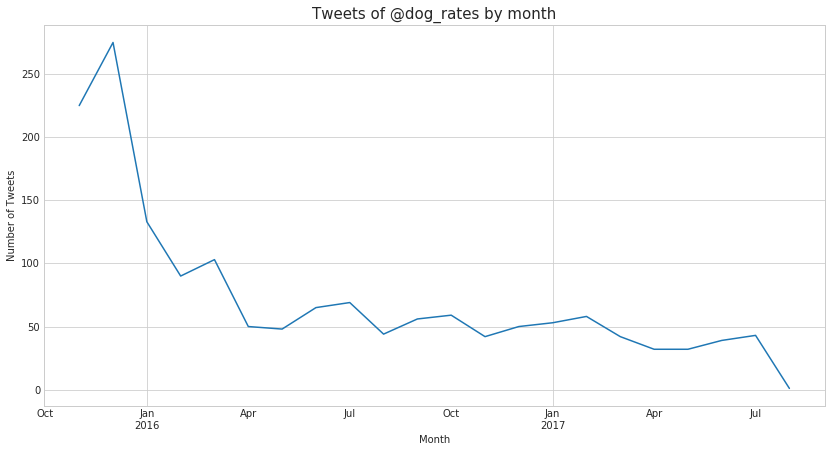

In [147]:
ax = tweets.timestamp.groupby(tweets.timestamp.dt.to_period('M')).agg('count').plot(figsize=(14,7))
ax.set_title('Tweets of @dog_rates by month').set_fontsize(15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Tweets');

Very interesting is that the number of Tweets dropped over time. Perhaps most of the Tweets are retweets now? Let's see the same plot from the original Data.

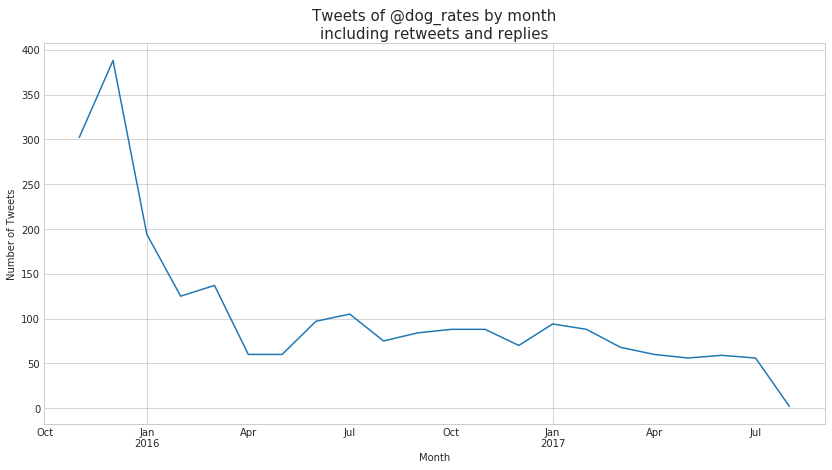

In [148]:
ax2 = df_tae.timestamp.astype('datetime64[ns]').groupby(df_tae.timestamp.astype('datetime64[ns]').dt.to_period('M')).agg('count').plot(figsize=(14,7))
ax2.set_title('Tweets of @dog_rates by month\nincluding retweets and replies').set_fontsize(15)
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Tweets');

The total number of Tweets is higher obviously but drops over time as well. How does that correlate with the popularity of this Twitter account?

### Retweets over time

What about Retweets.

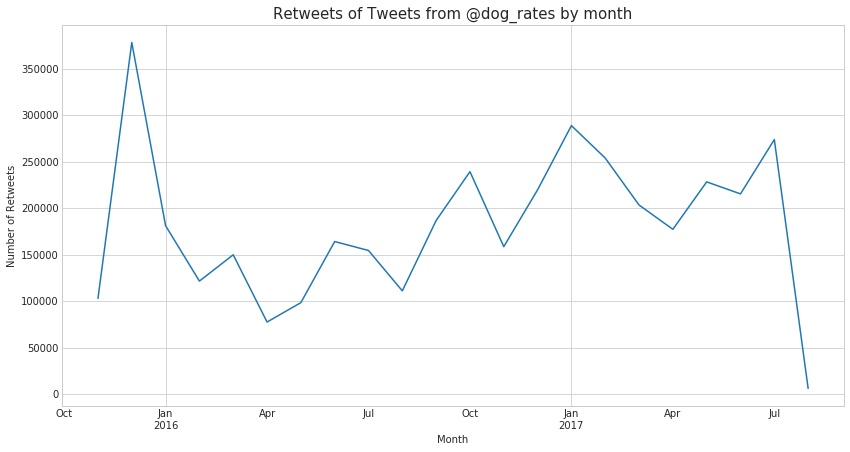

In [149]:
ax3 = tweets.retweet_count.groupby(tweets.timestamp.dt.to_period('M')).agg('sum').plot(figsize=(14,7))
ax3.set_title('Retweets of Tweets from @dog_rates by month').set_fontsize(15)
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Retweets');

The total number of retweets per month has ups and downs with a trend upwards.

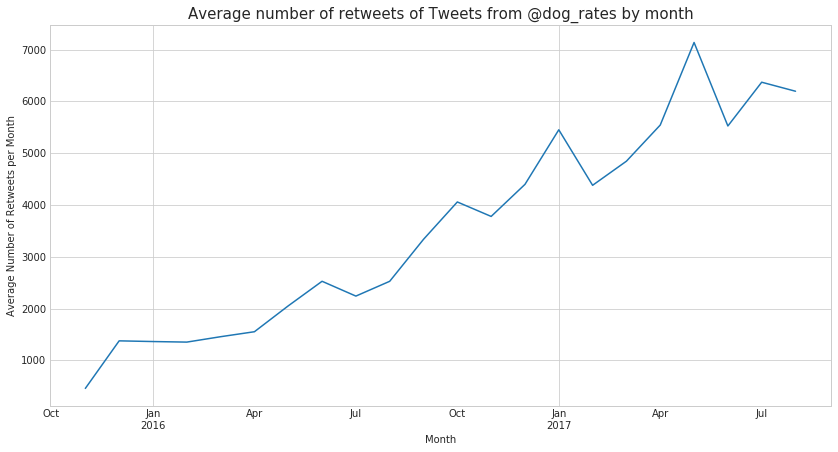

In [150]:
ax4 = tweets.retweet_count.groupby(tweets.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax4.set_title('Average number of retweets of Tweets from @dog_rates by month').set_fontsize(15)
ax4.set_xlabel('Month')
ax4.set_ylabel('Average Number of Retweets per Month');

This trend can be seen more clear in this plot. The average number of retweets raised over time. Obviously Twitter is very effective if one has lots' of followers. @dog_rates Tweets are retweeted alot.

### Favorites over time

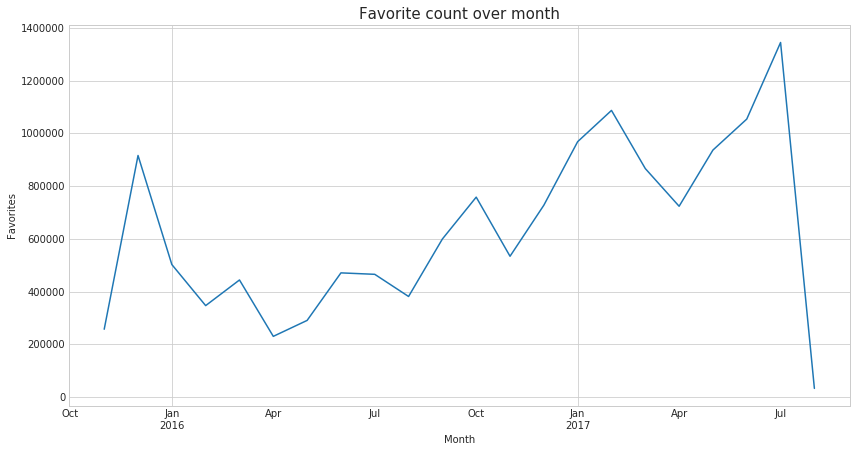

In [151]:
ax5 = tweets.favorite_count.groupby(tweets.timestamp.dt.to_period('M')).agg('sum').plot(figsize=(14,7))
ax5.set_title('Favorite count over month').set_fontsize(15)
ax5.set_xlabel('Month')
ax5.set_ylabel('Favorites');

As with retweets the trend upwards is visible. That's an effect that is expected because the more popular a Twitter account the more followers the more retweets and favorites.

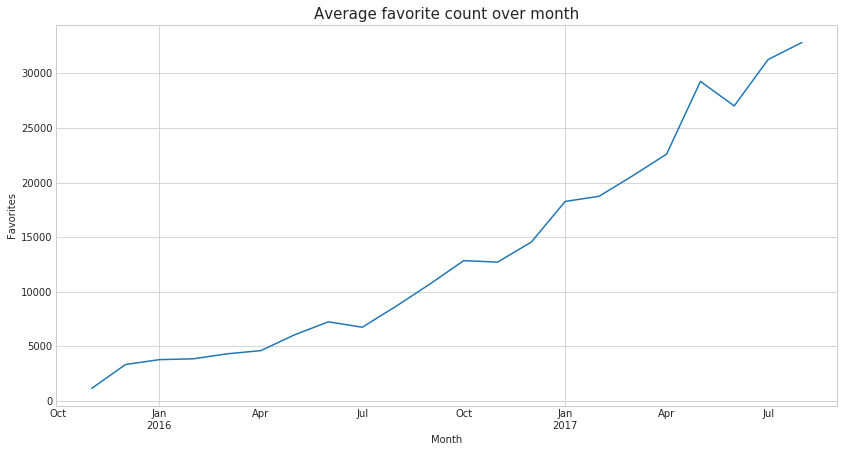

In [152]:
ax6 = tweets.favorite_count.groupby(tweets.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax6.set_title('Average favorite count over month').set_fontsize(15)
ax6.set_xlabel('Month')
ax6.set_ylabel('Favorites');

Again this is visible using the average number of favorites.

### Ratings over time

How did the ratings change over time?

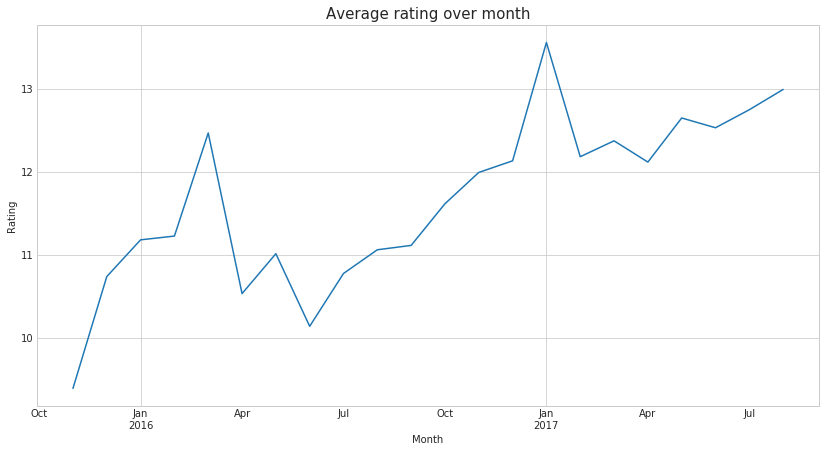

In [153]:
ax7 = tweets.rating_numerator.groupby(tweets.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax7.set_title('Average rating over month').set_fontsize(15)
ax7.set_xlabel('Month')
ax7.set_ylabel('Rating');

The two spikes here are for sure due to the fun ratings we saw earlier.

But it seems that over time the average rating increased. Does that correlate with the number of favorites and retweets?

In [154]:
tweets[tweets.rating_numerator < 15][['favorite_count', 'retweet_count', 'rating_numerator']].corr()

favorite_count  retweet_count  rating_numerator
favorite_count          1.000000       0.931722          0.435072
retweet_count           0.931722       1.000000          0.351489
rating_numerator        0.435072       0.351489          1.000000

Interesting: The rating does not correlate that much with the number of retweets and favorite counts. (I excluded the fun ratings here.) That means that the rating itself does not explain the high numbers of retweets.

In contrast the number of retweets and favorites correlate strong. This is expected because the more retweets the more people can favorite the tweet. And the opposite holds true as well I think: The more people favorite a Tweet the more people will retweet it.

I think that the rating itself is not the gist of these tweets but the Tweet text itself. I think this is due to the sense of humor of @dog_rates and the text he comments every image.

### Most and highest rated breeds

Let's see what breeds are most often rated.

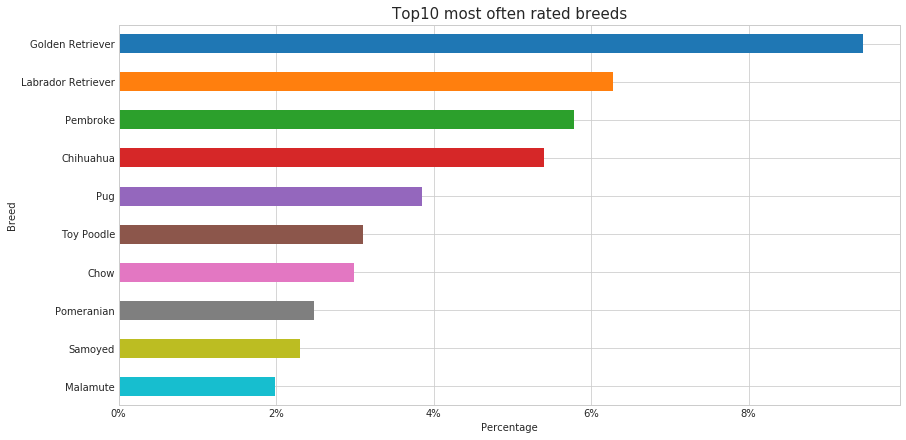

In [155]:
ax8 = tweets.breed.value_counts(normalize=True).nlargest(10).plot(kind = 'barh', figsize=(14,7))
ax8.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax8.invert_yaxis()
ax8.set_title('Top10 most often rated breeds').set_fontsize(15)
ax8.set_xlabel('Percentage')
ax8.set_ylabel('Breed');

We see here that most often **Golden Retrievers** were rated. But in addition we can see that there is a large amount of different breeds rated because the top 1 is below 10% of all Tweets.

What are the highest rated breeds?

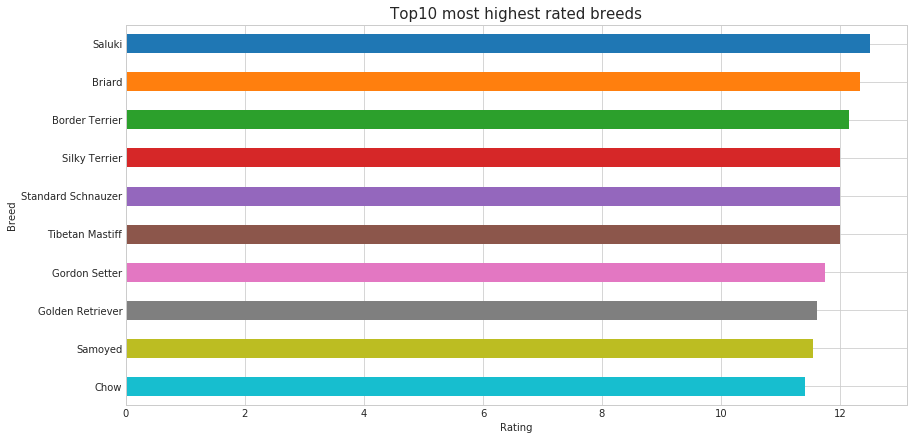

In [156]:
ax9 = tweets[tweets.rating_numerator < 15].groupby('breed').rating_numerator.mean().nlargest(10).plot(kind = 'barh', figsize=(14,7))
ax9.invert_yaxis()
ax9.set_title('Top10 most highest rated breeds').set_fontsize(15)
ax9.set_xlabel('Rating')
ax9.set_ylabel('Breed');

Contrary to this the highest rated breeds are **Saluki** and **Briard** and **Border Terrier** with an average rating above 12. **Golden Retriever** is at rank 8 in this list.

### Most used names

What are the most used names for dogs in this dataset?

In [157]:
names = tweets.name.str.cat(sep=' ')
stopwords = set(STOPWORDS)
dog_mask = np.array(Image.open('golden_retriever.jpg'))

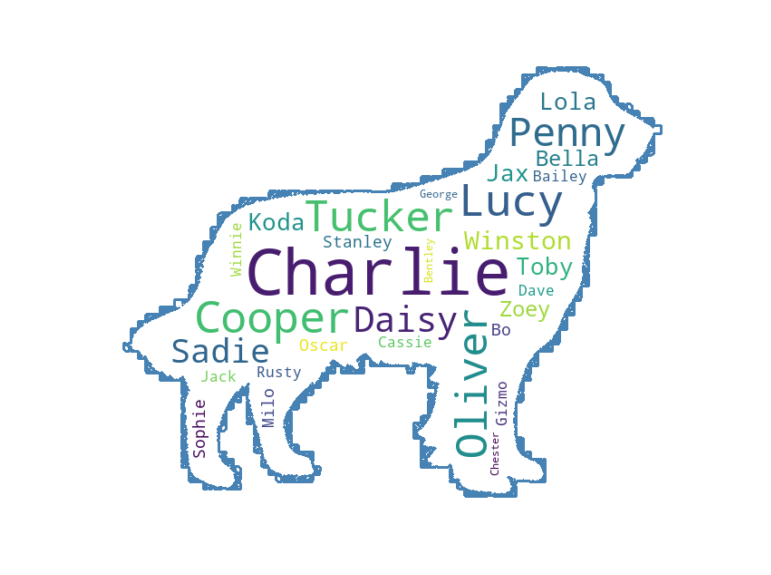

In [158]:
wc = WordCloud(background_color='white', margin=10, max_words=30, mask=dog_mask, 
               stopwords=stopwords, contour_width=3, contour_color='steelblue').generate(names)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

From this image it seems that the names **Cooper**, **Tucker**, **Lucy**, **Charlie** and **Oliver** are the most used names.

### Most used text words

Finally: What are the most used words in @dog_rates Tweets?

In [159]:
fulltext = tweets.text.str.cat(sep=' ')
stopwords.update(['Meet', 'hello', 'Say'])
tweet_mask = np.array(Image.open('twitter.png'))

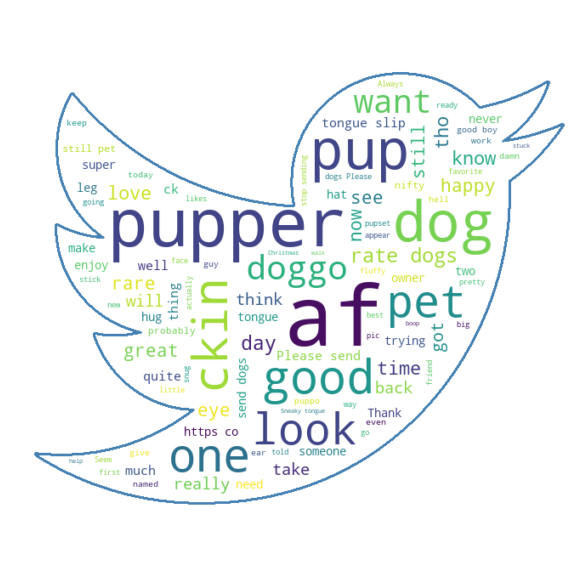

In [160]:
wc = WordCloud(background_color='white', margin=10, max_words=100, stopwords=stopwords, mask=tweet_mask,
               contour_width=3, contour_color='steelblue').generate(fulltext)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**af** and **pupper** seem to be the most used words in the Tweets contained in the archive.